In [12]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.model_selection
pd.options.mode.chained_assignment = None
sns.set()

In [13]:
FRAME_COLUMNS = [
    'blue_total_kills', 'blue_total_gold', 'blue_total_cs', 'blue_total_damage', 'blue_towers',
    'blue_plates', 'blue_inhibitors', 'blue_barons', 'blue_dragons', 'blue_rift_heralds',
    'red_total_kills', 'red_total_gold', 'red_total_cs', 'red_total_damage', 'red_towers',
    'red_plates', 'red_inhibitors', 'red_barons', 'red_dragons', 'red_rift_heralds'
]
ADVANTAGE_COLUMNS = [
    'kill_advantage', 'gold_advantage', 'cs_advantage', 'damage_advantage', 'tower_advantage',
    'plate_advantage', 'inhibitor_advantage', 'baron_advantage', 'dragon_advantage', 'rift_advantage'
]

In [14]:
# match dataset
df = pd.read_csv('../data/raw/lol-data-matches.csv')
# match frames dataset
df1 = pd.read_csv('../data/raw/lol-data-match-frames.csv')

## Data

In [15]:
# match dataset
df = pd.read_csv('../data/raw/lol-data-matches.csv')
# match frames dataset
df1 = pd.read_csv('../data/raw/lol-data-match-frames.csv')
# class labels
blue, red = -1, 1
frame = 25
random_state = 0
dpi = 300
# filter by frame
df1 = df1[df1['frame'] == frame]

# highlighting the number of duplicate data points in datasets
print('Number of duplicate data points in lol-data-matches.csv: '
     + str(df.duplicated(subset=['match_id']).sum()))
print('Number of duplicate data points in lol-data-match-frames.csv: '
     + str(df1.duplicated(subset=['match_id']).sum()))

# Discarding duplicate data points
df.drop_duplicates(subset=['match_id'], inplace=True)
df1.drop_duplicates(subset=['match_id'], inplace=True)

# Merging on the match data frames as some matches might end before the selected frame
df = pd.merge(df1, df, on='match_id')

# highlighting data points with missing features
print('Number of data points with missing features: ')
for f in df.columns[df.isna().any()].tolist():
    print(f + ': ' + str(df.loc[df[f].isna()].shape[0]))

# Discarding data points with missing class label
df.dropna(subset=['winning_team'], inplace=True)

# highlighting initial set of features, class and tier distribution
print('Initial set of features:\n', df.columns.tolist())
print('Total number of data points: ' + str(df.shape[0]))
print('Initial class distribution:\nBlue: ' + '%.2f%%' % ((df.groupby('winning_team').size().tolist()[0]/df.shape[0])*100)
      + '\nRed: ' + '%.2f%%' % ((df.groupby('winning_team').size().tolist()[1]/df.shape[0])*100))
print('Initial tier distribution: \nBronze: ', df.groupby('tier').size().tolist()[0],
     '\nGold:', df.groupby('tier').size().tolist()[1], '\nDiamond:', df.groupby('tier').size().tolist()[2],
     '\nGrandmaster:', df.groupby('tier').size().tolist()[3])
df.describe()

Number of duplicate data points in lol-data-matches.csv: 80
Number of duplicate data points in lol-data-match-frames.csv: 0
Number of data points with missing features: 
winning_team: 1
first_champion: 95
first_inhibitor: 1023
first_baron: 4125
first_dragon: 2
first_rift_herald: 1826
Initial set of features:
 ['match_id', 'frame', 'blue_total_kills', 'blue_total_gold', 'blue_total_cs', 'blue_total_damage', 'blue_towers', 'blue_plates', 'blue_inhibitors', 'blue_barons', 'blue_dragons', 'blue_rift_heralds', 'red_total_kills', 'red_total_gold', 'red_total_cs', 'red_total_damage', 'red_towers', 'red_plates', 'red_inhibitors', 'red_barons', 'red_dragons', 'red_rift_heralds', 'tier', 'division', 'patch', 'game_duration', 'region', 'winning_team', 'first_champion', 'first_tower', 'first_inhibitor', 'first_baron', 'first_dragon', 'first_rift_herald']
Total number of data points: 26503
Initial class distribution:
Blue: 50.24%
Red: 49.76%
Initial tier distribution: 
Bronze:  8545 
Gold: 7023 
Di

,frame,blue_total_kills,blue_total_gold,blue_total_cs,blue_total_damage,blue_towers,blue_plates,blue_inhibitors,blue_barons,blue_dragons,...,red_rift_heralds,patch,game_duration,winning_team,first_champion,first_tower,first_inhibitor,first_baron,first_dragon,first_rift_herald
count,26503.0,26503.000000,26503.000000,26503.000000,26503.000000,26503.000000,26503.000000,26503.000000,26503.000000,26503.000000,...,26503.000000,26503.000000,26503.000000,26503.000000,26408.000000,26503.000000,25480.000000,22378.000000,26501.000000,24677.000000
mean,25.0,23.489077,46368.470966,634.957250,64389.033996,3.516281,5.966570,0.168170,0.181791,1.503641,...,0.651926,11.232137,1889.525978,149.756631,149.553166,148.926537,149.014914,151.434445,152.084827,146.338696
std,0.0,7.321355,4872.028454,90.445933,12222.859931,2.125618,3.071055,0.476109,0.385679,1.055179,...,0.701939,0.179024,318.954011,50.000351,49.998950,49.989419,49.991276,49.980536,49.957459,49.866779
min,25.0,2.000000,28731.000000,304.000000,21233.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,10.250000,1440.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
25%,25.0,18.000000,43055.500000,572.000000,55953.500000,2.000000,4.000000,0.000000,0.000000,1.000000,...,0.000000,11.180000,1645.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
50%,25.0,23.000000,46300.000000,640.000000,63823.000000,3.000000,6.000000,0.000000,0.000000,1.000000,...,1.000000,11.210000,1834.000000,100.000000,100.000000,100.000000,100.000000,200.000000,200.000000,100.000000
75%,25.0,28.000000,49634.500000,701.000000,72236.000000,5.000000,8.000000,0.000000,0.000000,2.000000,...,1.000000,11.210000,2072.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
max,25.0,62.000000,66058.000000,928.000000,118208.000000,11.000000,15.000000,5.000000,1.000000,4.000000,...,2.000000,11.900000,3649.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000


## Data Preprocessing

### Sampling

In [16]:
# Sampling equal number of data points from each tier
n = 4900
TIERS = ['BRONZE', 'GOLD', 'DIAMOND', 'GRANDMASTERS']
df = pd.concat([df[df['tier'] == t].sample(n, random_state=random_state) for t in TIERS])

In [17]:
print('Sample size: ' + str(df.shape[0]) + 
      '\nSample class distribution:\nBlue: ' + '%.2f%%' % ((df.groupby('winning_team').size().tolist()[0]/df.shape[0])*100)
      + '\nRed: ' + '%.2f%%' % ((df.groupby('winning_team').size().tolist()[1]/df.shape[0])*100))
df.shape

Sample size: 19600
Sample class distribution:
Blue: 50.06%
Red: 49.94%


(19600, 34)

### Data Cleaning and Formatting

In [18]:
# Discarding irrelevant features
df.drop(columns=['game_duration', 'match_id', 'frame', 'division', 'patch', 'region'], inplace=True)

# Replacing missing values with 0 and class labels with chosen values
df.replace({200: red, 100: blue, np.nan:0}, inplace=True)
df.rename(columns={'winning_team': 'winner', 'first_champion':'first_kill'}, inplace=True)

In [19]:
print('Sample size after data cleaning: ' + str(df.shape[0]) +
      '\nSet of features after removing irrelevant features and renaming:\n', df.columns.tolist())

Sample size after data cleaning: 19600
Set of features after removing irrelevant features and renaming:
 ['blue_total_kills', 'blue_total_gold', 'blue_total_cs', 'blue_total_damage', 'blue_towers', 'blue_plates', 'blue_inhibitors', 'blue_barons', 'blue_dragons', 'blue_rift_heralds', 'red_total_kills', 'red_total_gold', 'red_total_cs', 'red_total_damage', 'red_towers', 'red_plates', 'red_inhibitors', 'red_barons', 'red_dragons', 'red_rift_heralds', 'tier', 'winner', 'first_kill', 'first_tower', 'first_inhibitor', 'first_baron', 'first_dragon', 'first_rift_herald']


### Feature Transformation

#### Binary
Adding an advantage column for each objective and filling the rows by comparing objective values in the teams columns.
If red = blue the value assigned to the advantage column will be 0 else if red > blue the value will be 1 else it will be -1.
Discarding the objective columns once the advantage column is built.

#### Difference
Adding an advantage column for each objective and filling the rows by subtracting the objective values in the teams columns.
If red = blue the value assigned to the advantage column will be 0 else if red > blue the value will be positive else it will be Negative.
Discarding the objective columns once the advantage column is built.

In [20]:
# Deep copy of the df
altered_df = df[FRAME_COLUMNS].copy(deep=True)
df_copy = df.copy(deep=True).reset_index()

#  Collapse each blue features to their red features by subtracting them
def combine(x, binary=False):
    x = x.reshape(2,10)
    if binary:
        return np.where(x[0] == x[1], 0, np.where(x[0] > x[1], blue, red))
    else:
        return x[1] - x[0] 

altered_df_diff = pd.DataFrame(data=np.apply_along_axis(combine, 1, altered_df.values), columns=ADVANTAGE_COLUMNS)
altered_df_bi = pd.DataFrame(data=np.apply_along_axis(combine, 1, altered_df.values, binary=True), columns=ADVANTAGE_COLUMNS)
df_bi = pd.concat([df_copy, altered_df_bi.fillna(0)], axis=1)
df_diff = pd.concat([df_copy, altered_df_diff], axis=1)


In [21]:
print('Sample size after binary feature transformation: ' + str(df_bi.shape[0]) +
      '\nSet of features after binary feature transformation:\n', df_bi.columns.tolist())

Sample size after binary feature transformation: 19600
Set of features after binary feature transformation:
 ['index', 'blue_total_kills', 'blue_total_gold', 'blue_total_cs', 'blue_total_damage', 'blue_towers', 'blue_plates', 'blue_inhibitors', 'blue_barons', 'blue_dragons', 'blue_rift_heralds', 'red_total_kills', 'red_total_gold', 'red_total_cs', 'red_total_damage', 'red_towers', 'red_plates', 'red_inhibitors', 'red_barons', 'red_dragons', 'red_rift_heralds', 'tier', 'winner', 'first_kill', 'first_tower', 'first_inhibitor', 'first_baron', 'first_dragon', 'first_rift_herald', 'kill_advantage', 'gold_advantage', 'cs_advantage', 'damage_advantage', 'tower_advantage', 'plate_advantage', 'inhibitor_advantage', 'baron_advantage', 'dragon_advantage', 'rift_advantage']


In [22]:
df_bi.drop(columns=['index'], inplace=True)
df_diff.drop(columns=['index'], inplace=True)
df_bi.drop(columns=FRAME_COLUMNS, inplace=True)
df_diff.drop(columns=FRAME_COLUMNS, inplace=True)

# # Dragon, inhibitor, rift_herald are available after the 5th minute
if frame < 5:
    df_bi.drop(columns=['dragon_advantage', 'inhibitor_advantage', 'rift_advantage'], inplace=True)
    df_diff.drop(columns=['dragon_advantage', 'inhibitor_advantage', 'rift_advantage'], inplace=True)

# # Baron is available after the 20th minute
if frame < 20:
    df_bi.drop(columns=['baron_advantage'], inplace=True)
    df_diff.drop(columns=['baron_advantage'], inplace=True)

In [23]:
print('Sample size after difference feature transformation: ' + str(df_diff.shape[0]) +
    '\nSet of features after difference feature transformation:\n', df_diff.columns.tolist())

Sample size after difference feature transformation: 19600
Set of features after difference feature transformation:
 ['tier', 'winner', 'first_kill', 'first_tower', 'first_inhibitor', 'first_baron', 'first_dragon', 'first_rift_herald', 'kill_advantage', 'gold_advantage', 'cs_advantage', 'damage_advantage', 'tower_advantage', 'plate_advantage', 'inhibitor_advantage', 'baron_advantage', 'dragon_advantage', 'rift_advantage']


## Feature Importance Analysis
Splitting the data into training and test sets. Training data will be used for feature importance analysis.
Splitting each tier separately and stratifying the class label to maintain same tier distribution in training and test sets.

In [24]:
bronze = df_bi[df_bi['tier'] == 'BRONZE']
gold = df_bi[df_bi['tier'] == 'GOLD']
diamond = df_bi[df_bi['tier'] == 'DIAMOND']
gm = df_bi[df_bi['tier'] == 'GRANDMASTERS']
bronze_trn, bronze_tst = sklearn.model_selection.train_test_split(bronze, train_size=0.8, test_size=0.2,
                            random_state=random_state, stratify=bronze['winner'])
gold_trn, gold_tst = sklearn.model_selection.train_test_split(gold, train_size=0.8, test_size=0.2,
                            random_state=random_state, stratify=gold['winner'])
diamond_trn, diamond_tst = sklearn.model_selection.train_test_split(diamond, train_size=0.8, test_size=0.2,
                            random_state=random_state, stratify=diamond['winner'])
gm_trn, gm_tst = sklearn.model_selection.train_test_split(gm, train_size=0.8, test_size=0.2,
                            random_state=random_state, stratify=gm['winner'])
df_bi_trn = bronze_trn.append([gold_trn, diamond_trn, gm_trn])
df_bi_tst = bronze_tst.append([gold_tst, diamond_tst, gm_tst])

In [25]:
print('Number of data points in training set: ' + str(df_bi_trn.shape[0]) + 
      '\nNumber of data points in test set: ' + str(df_bi_tst.shape[0]) +
      '\nClass distribution in training data:\nBlue: ' + '%.2f%%' % ((df_bi_trn.groupby('winner').size().tolist()[0]/df_bi_trn.shape[0])*100)
      + '\nRed: ' + '%.2f%%' % ((df_bi_trn.groupby('winner').size().tolist()[1]/df_bi_trn.shape[0])*100))

Number of data points in training set: 15680
Number of data points in test set: 3920
Class distribution in training data:
Blue: 50.06%
Red: 49.94%


### Binary Features

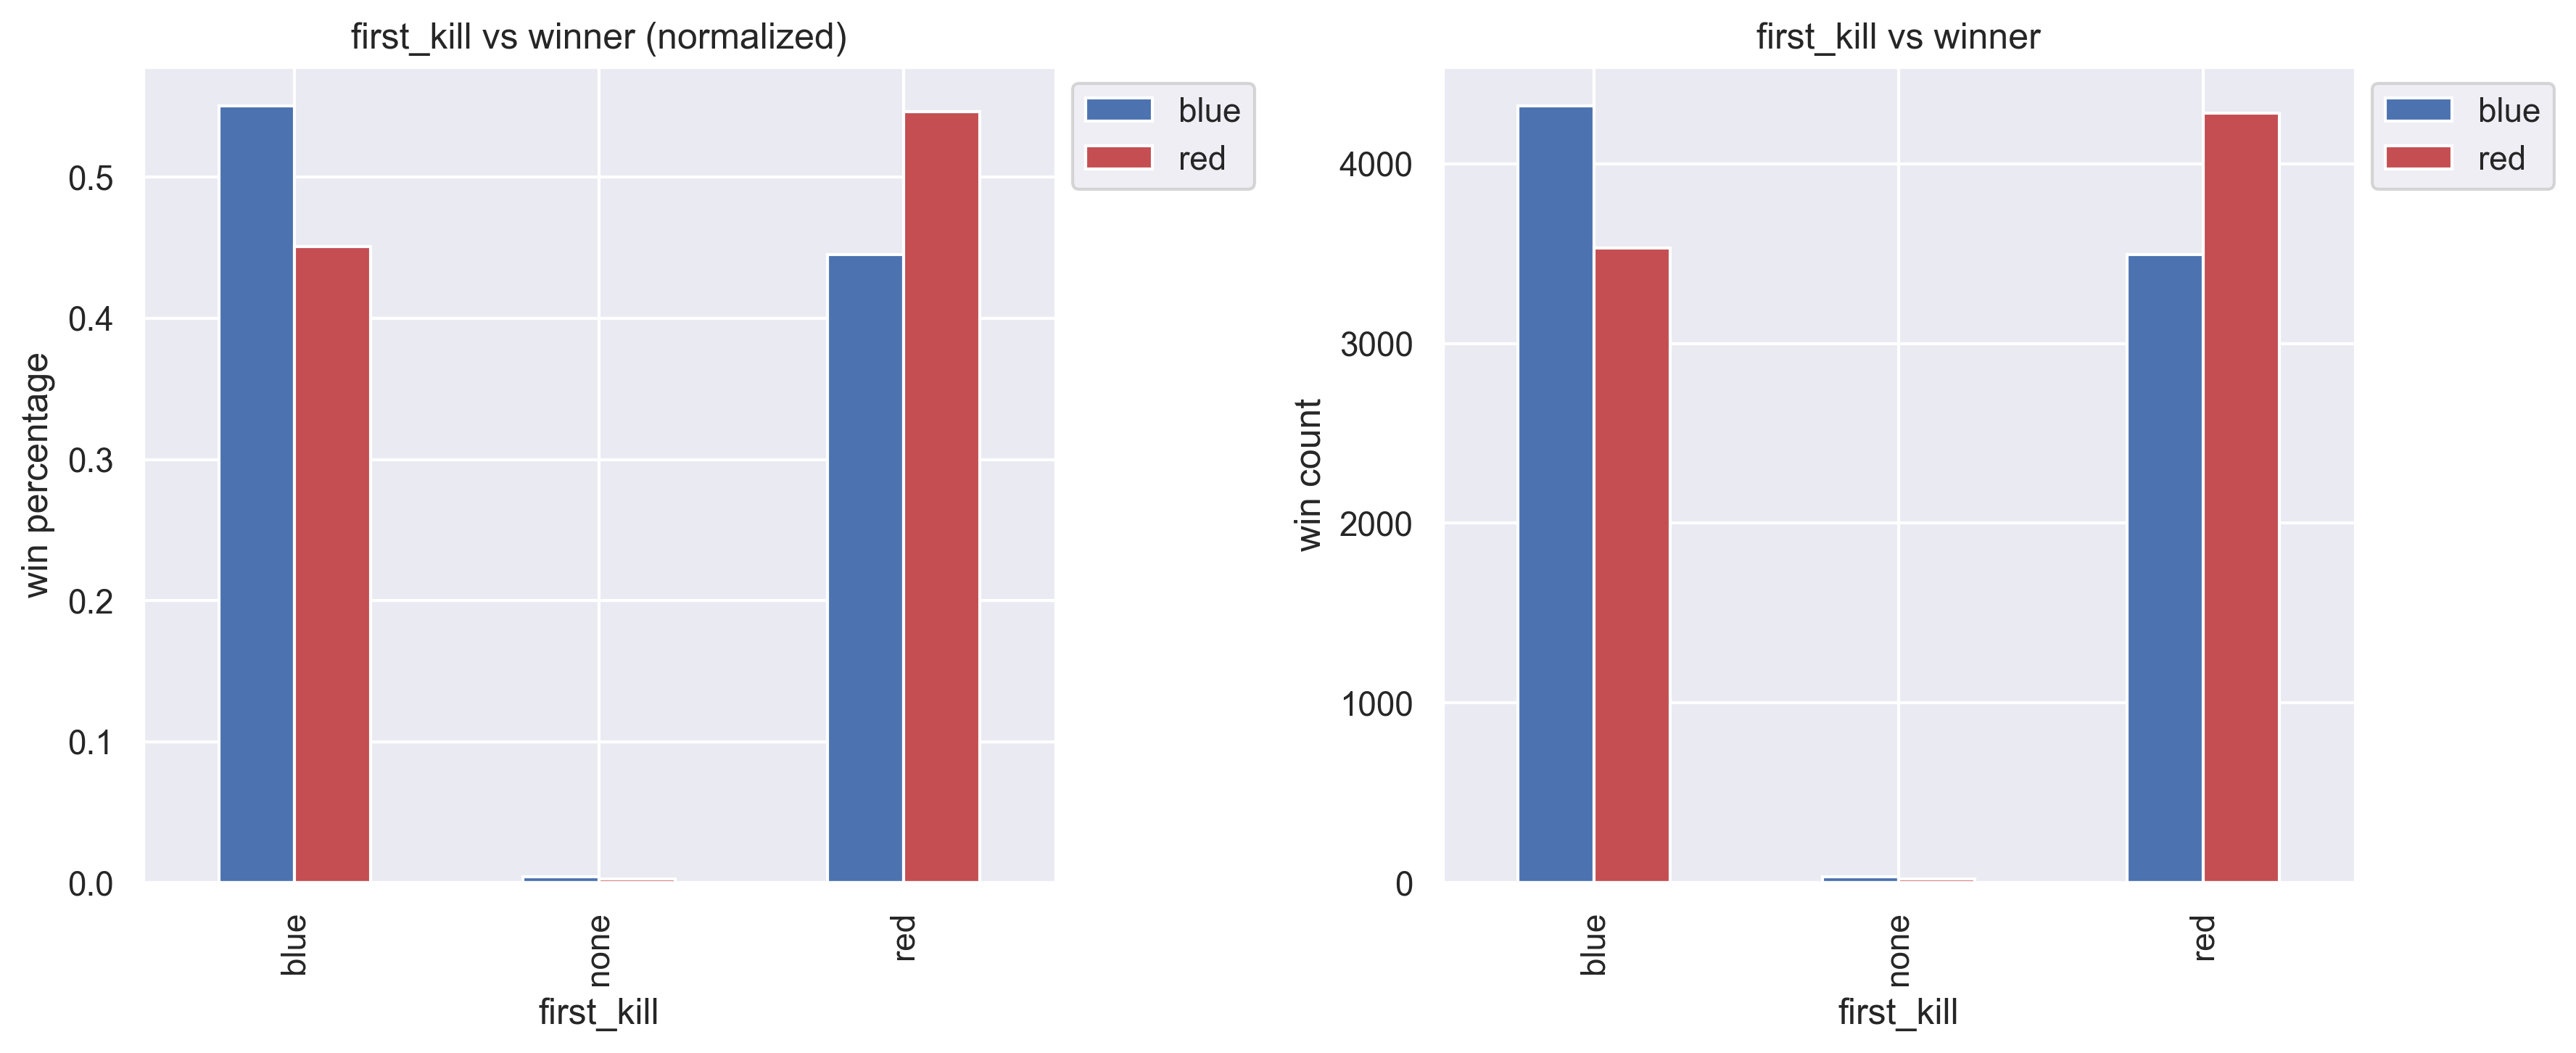

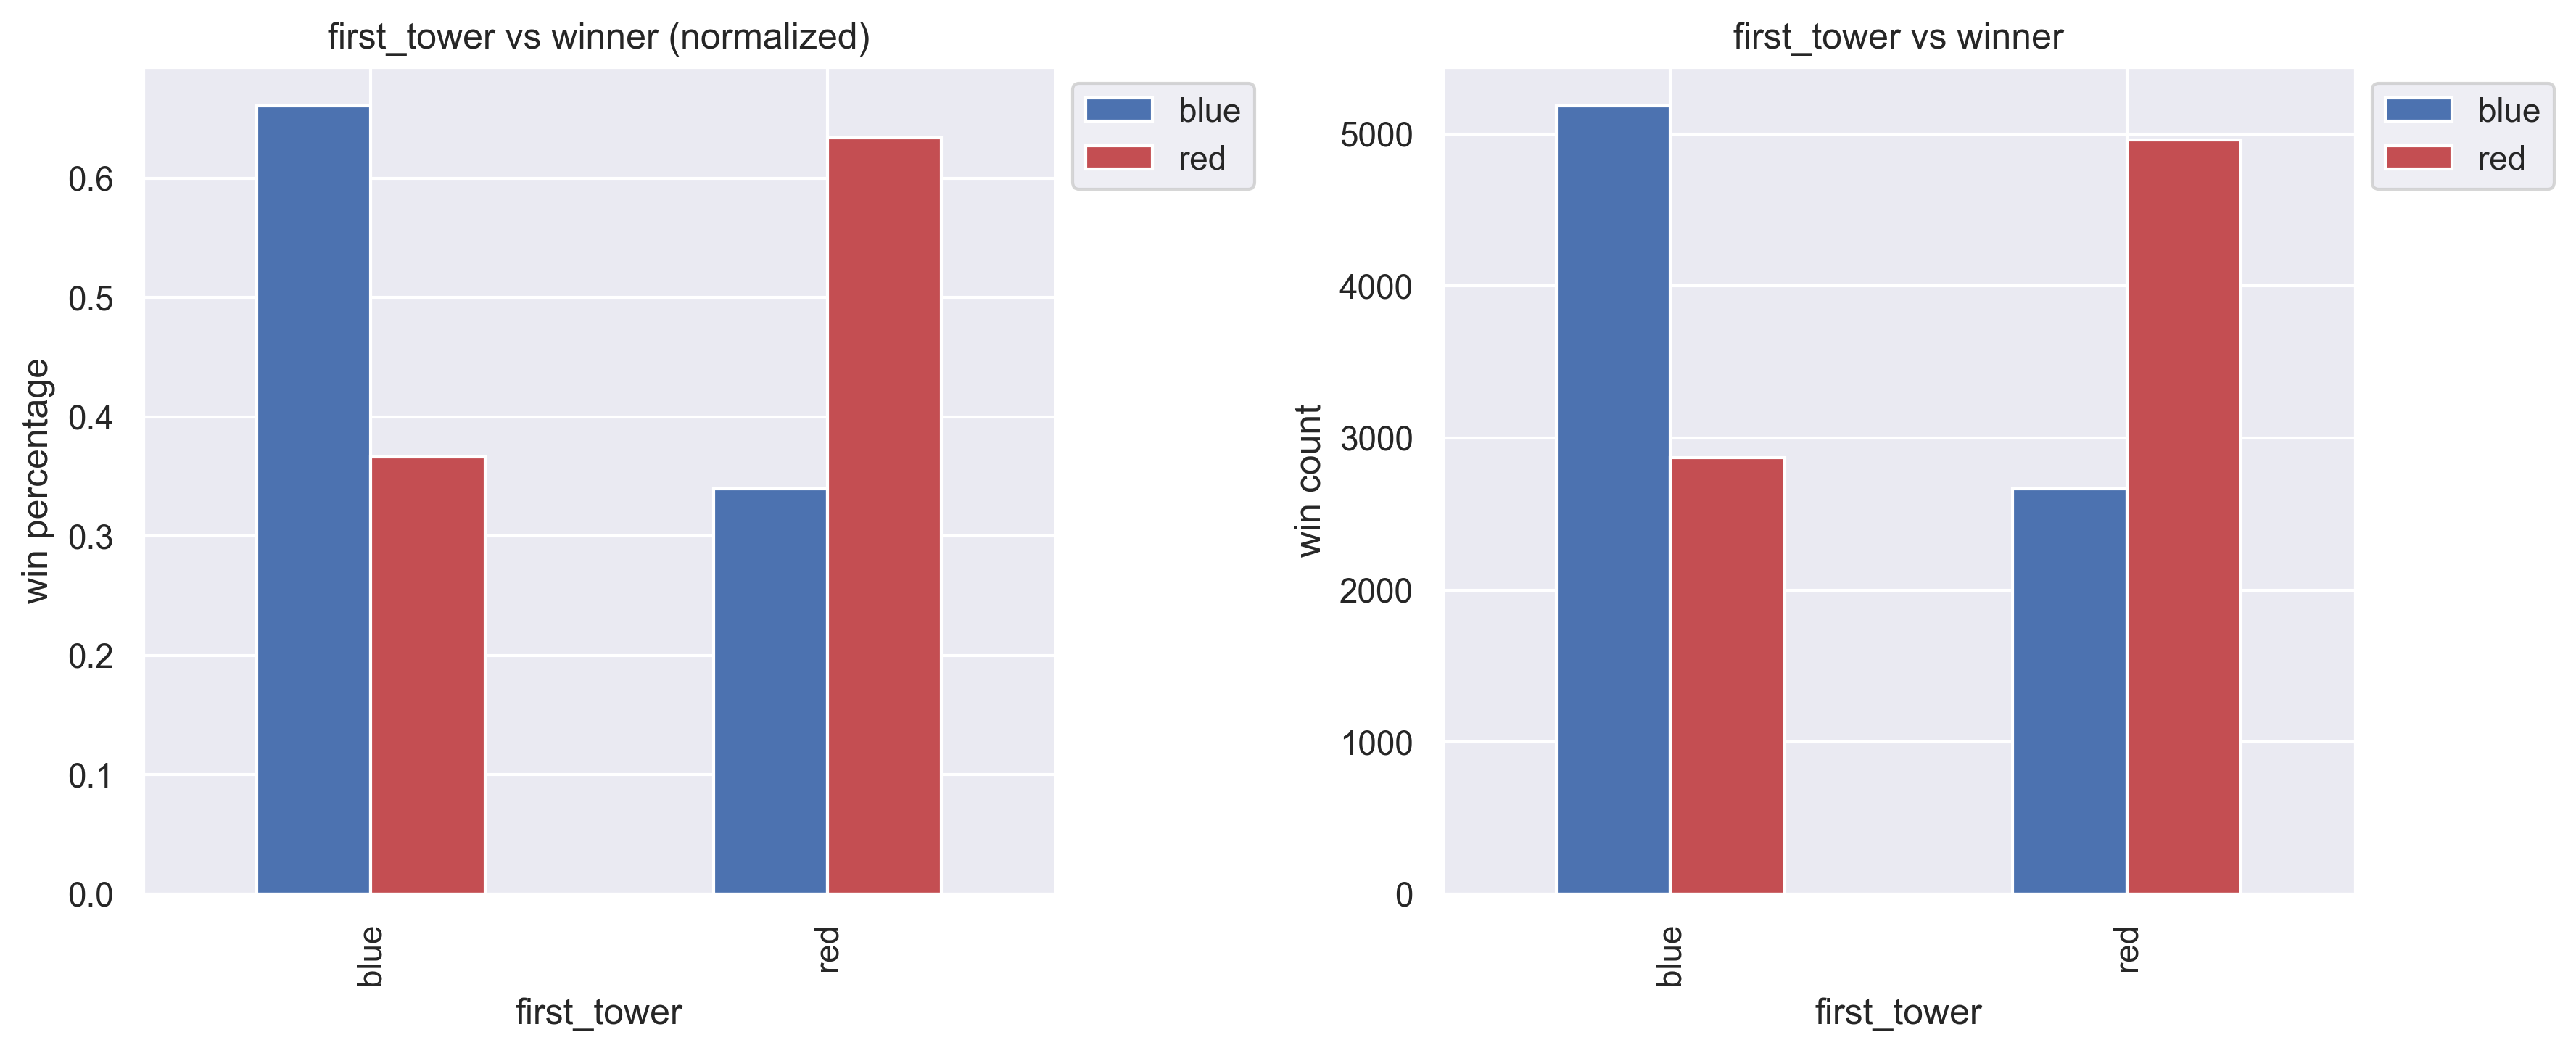

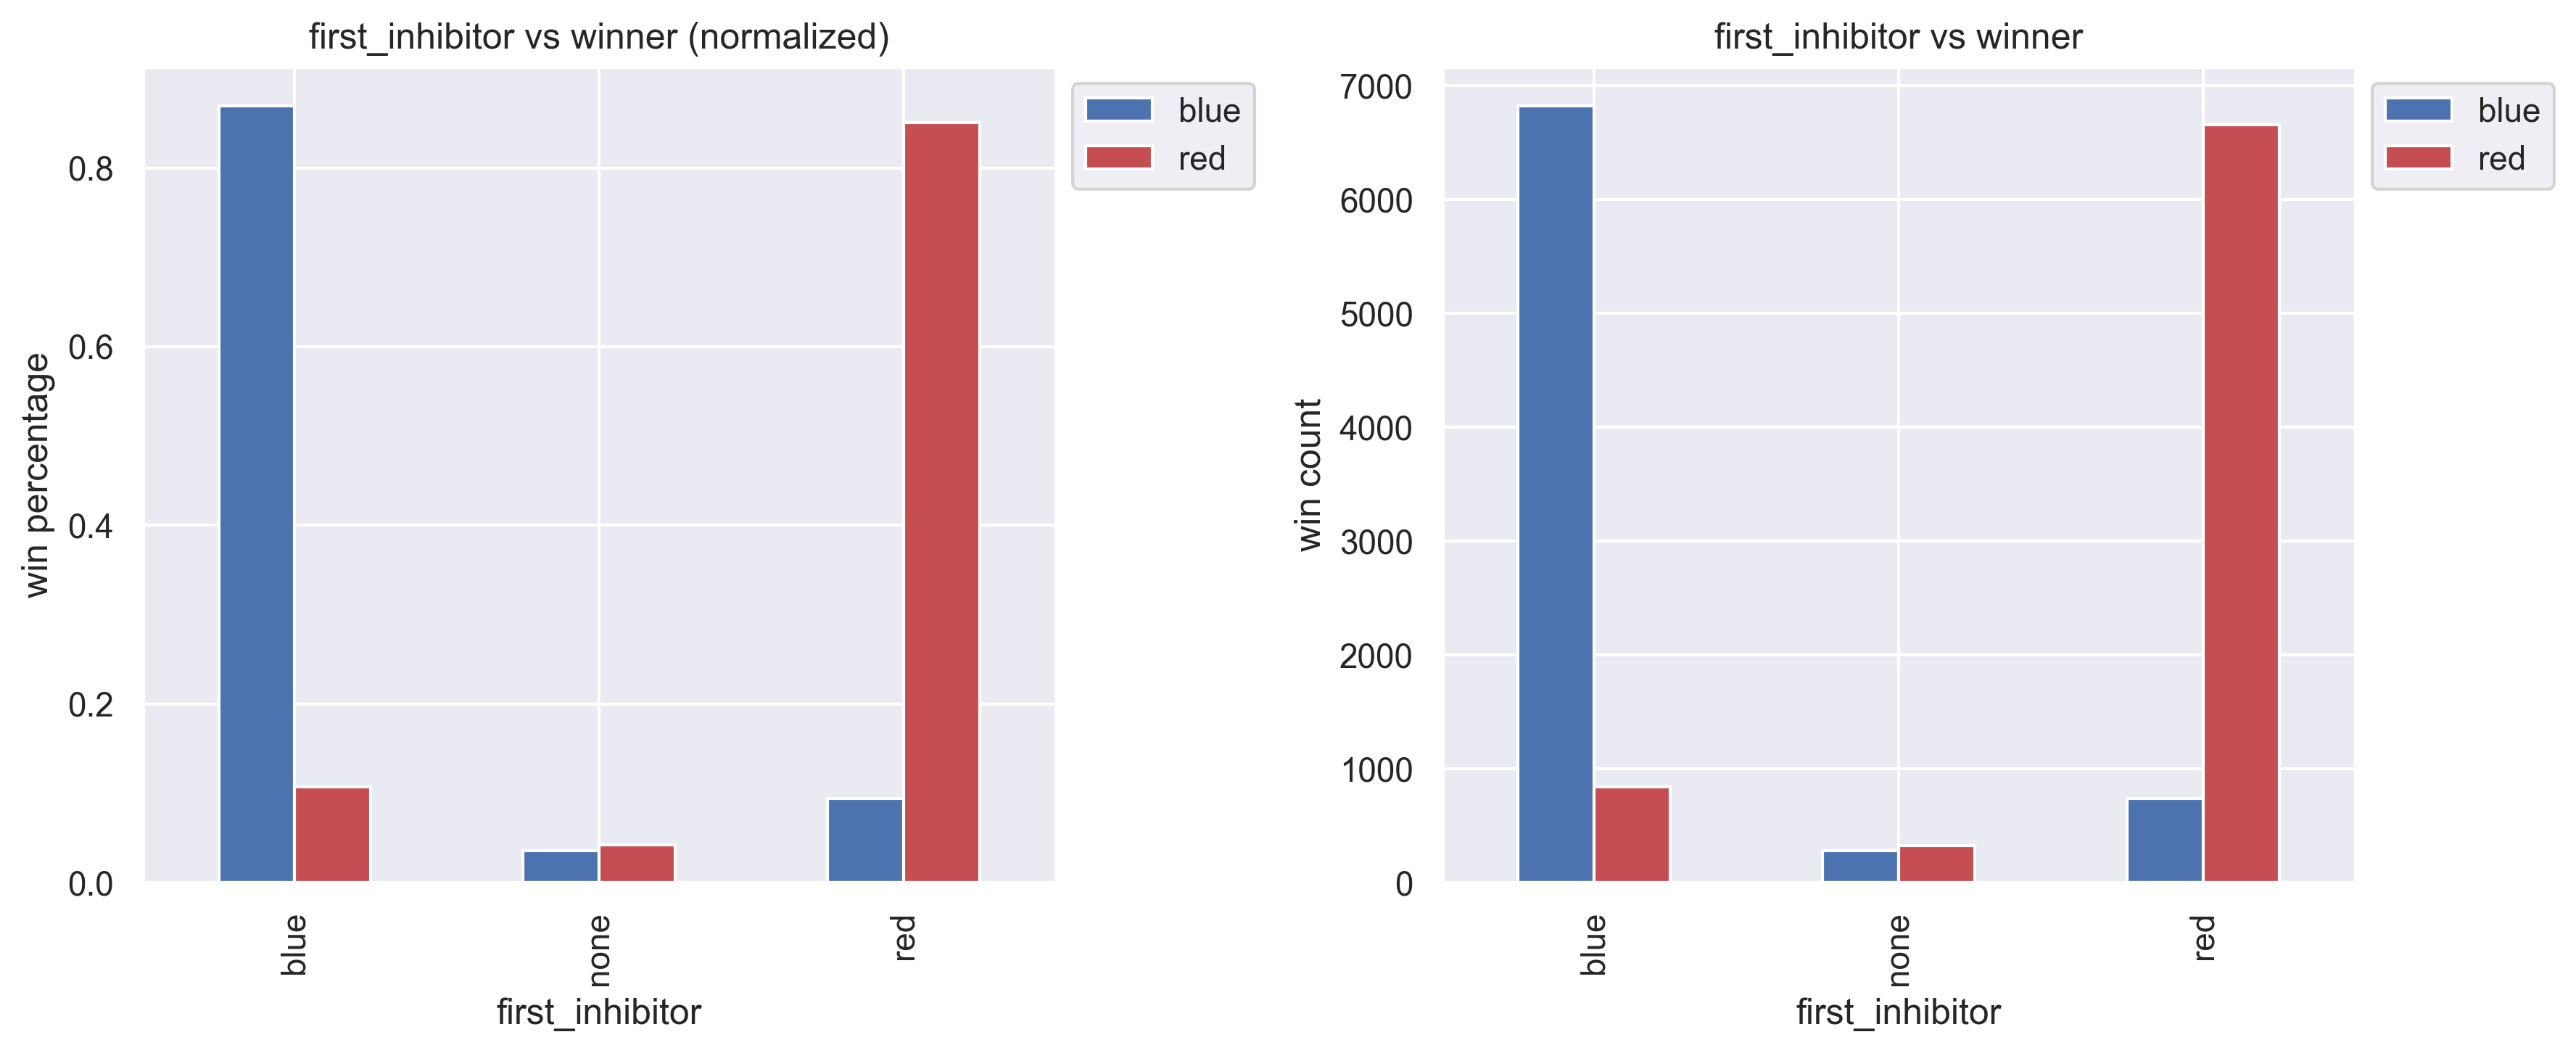

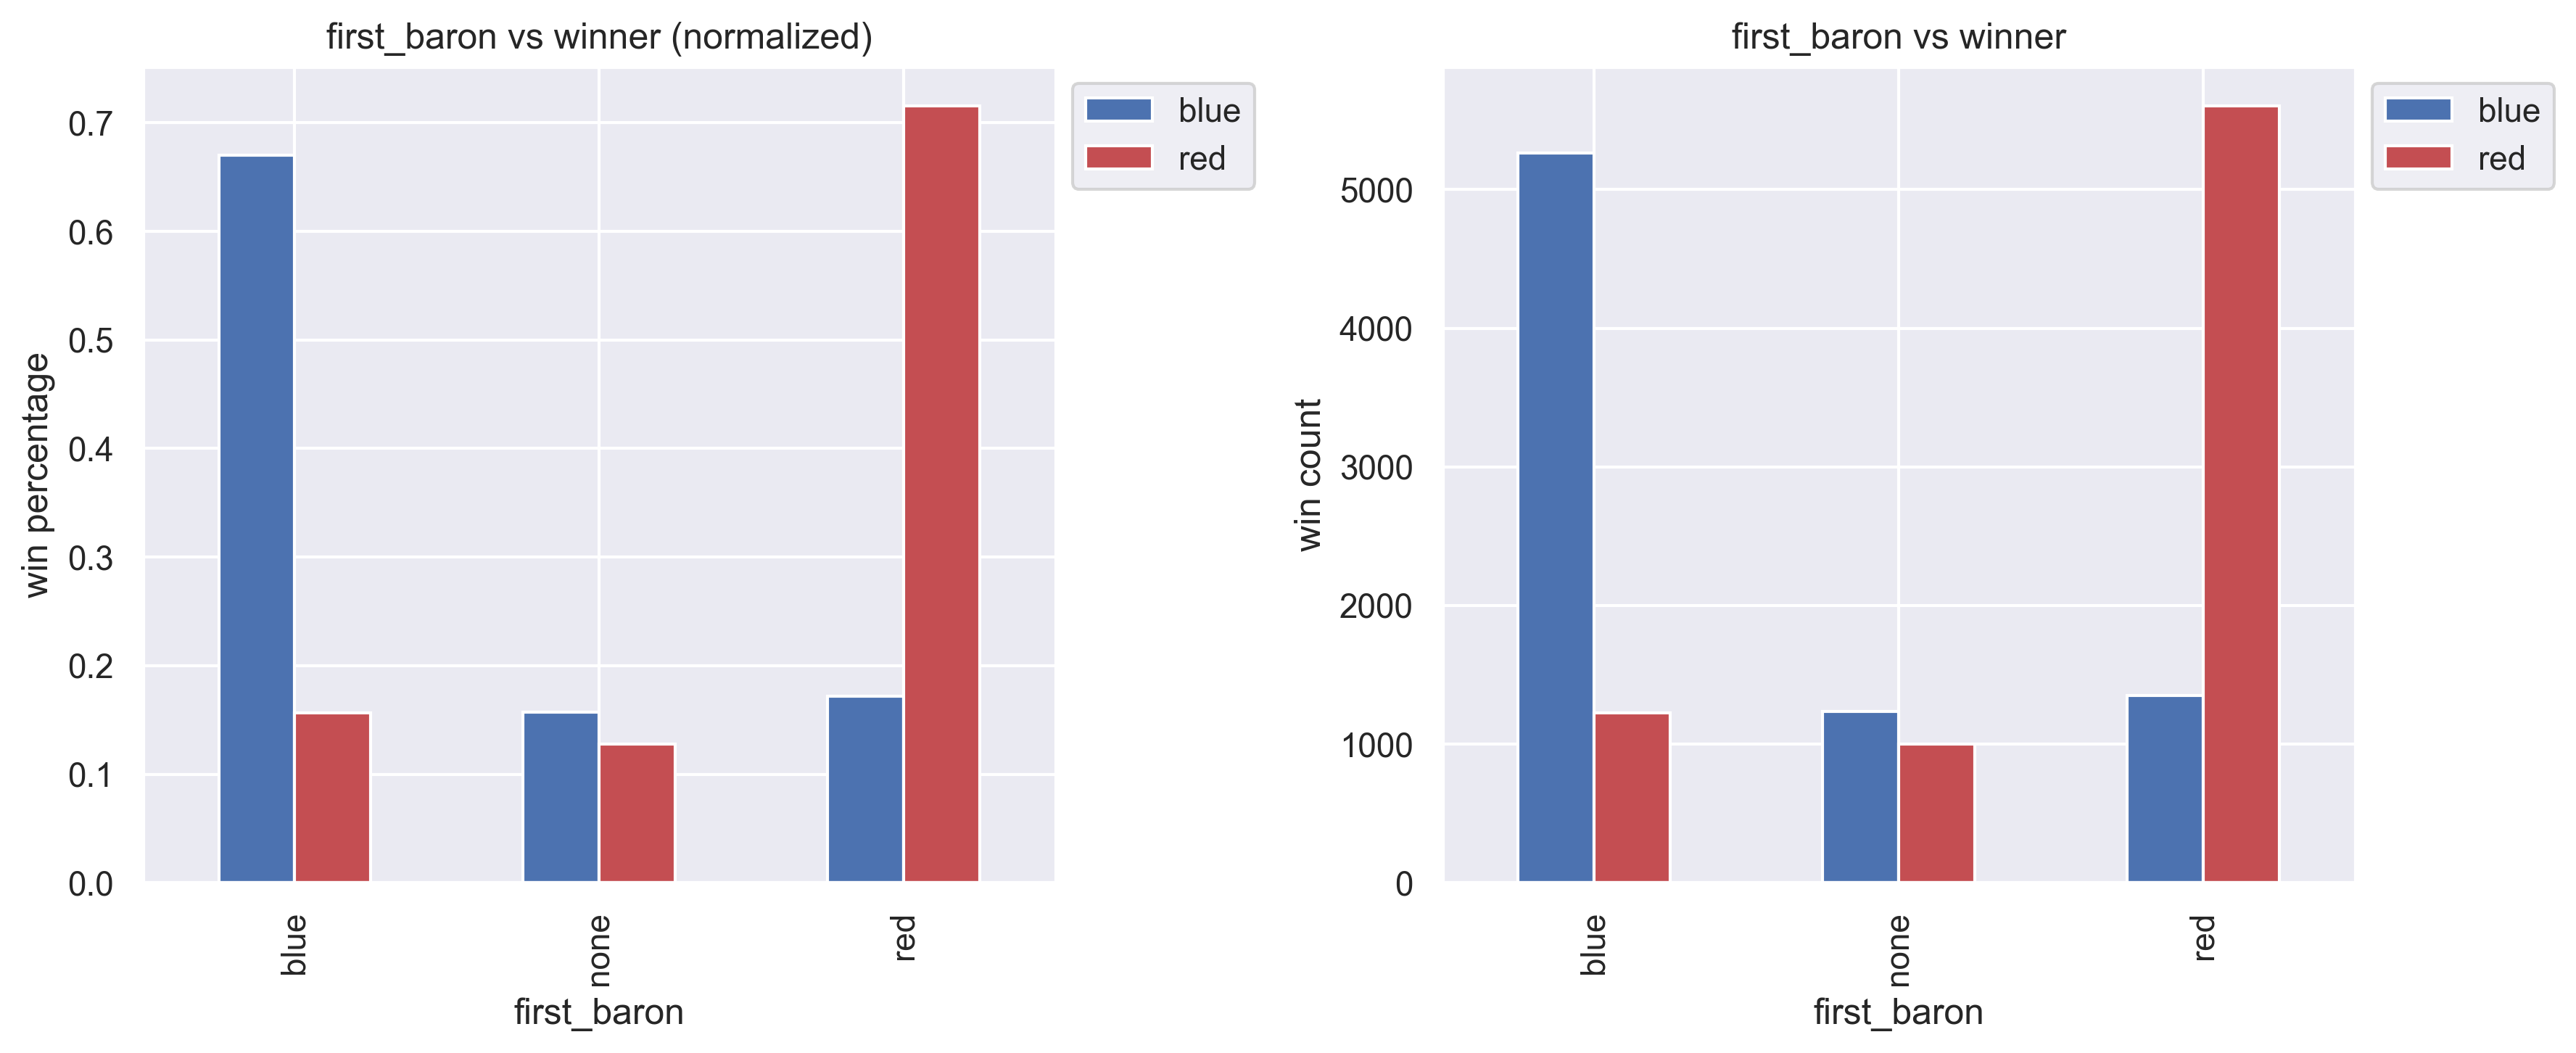

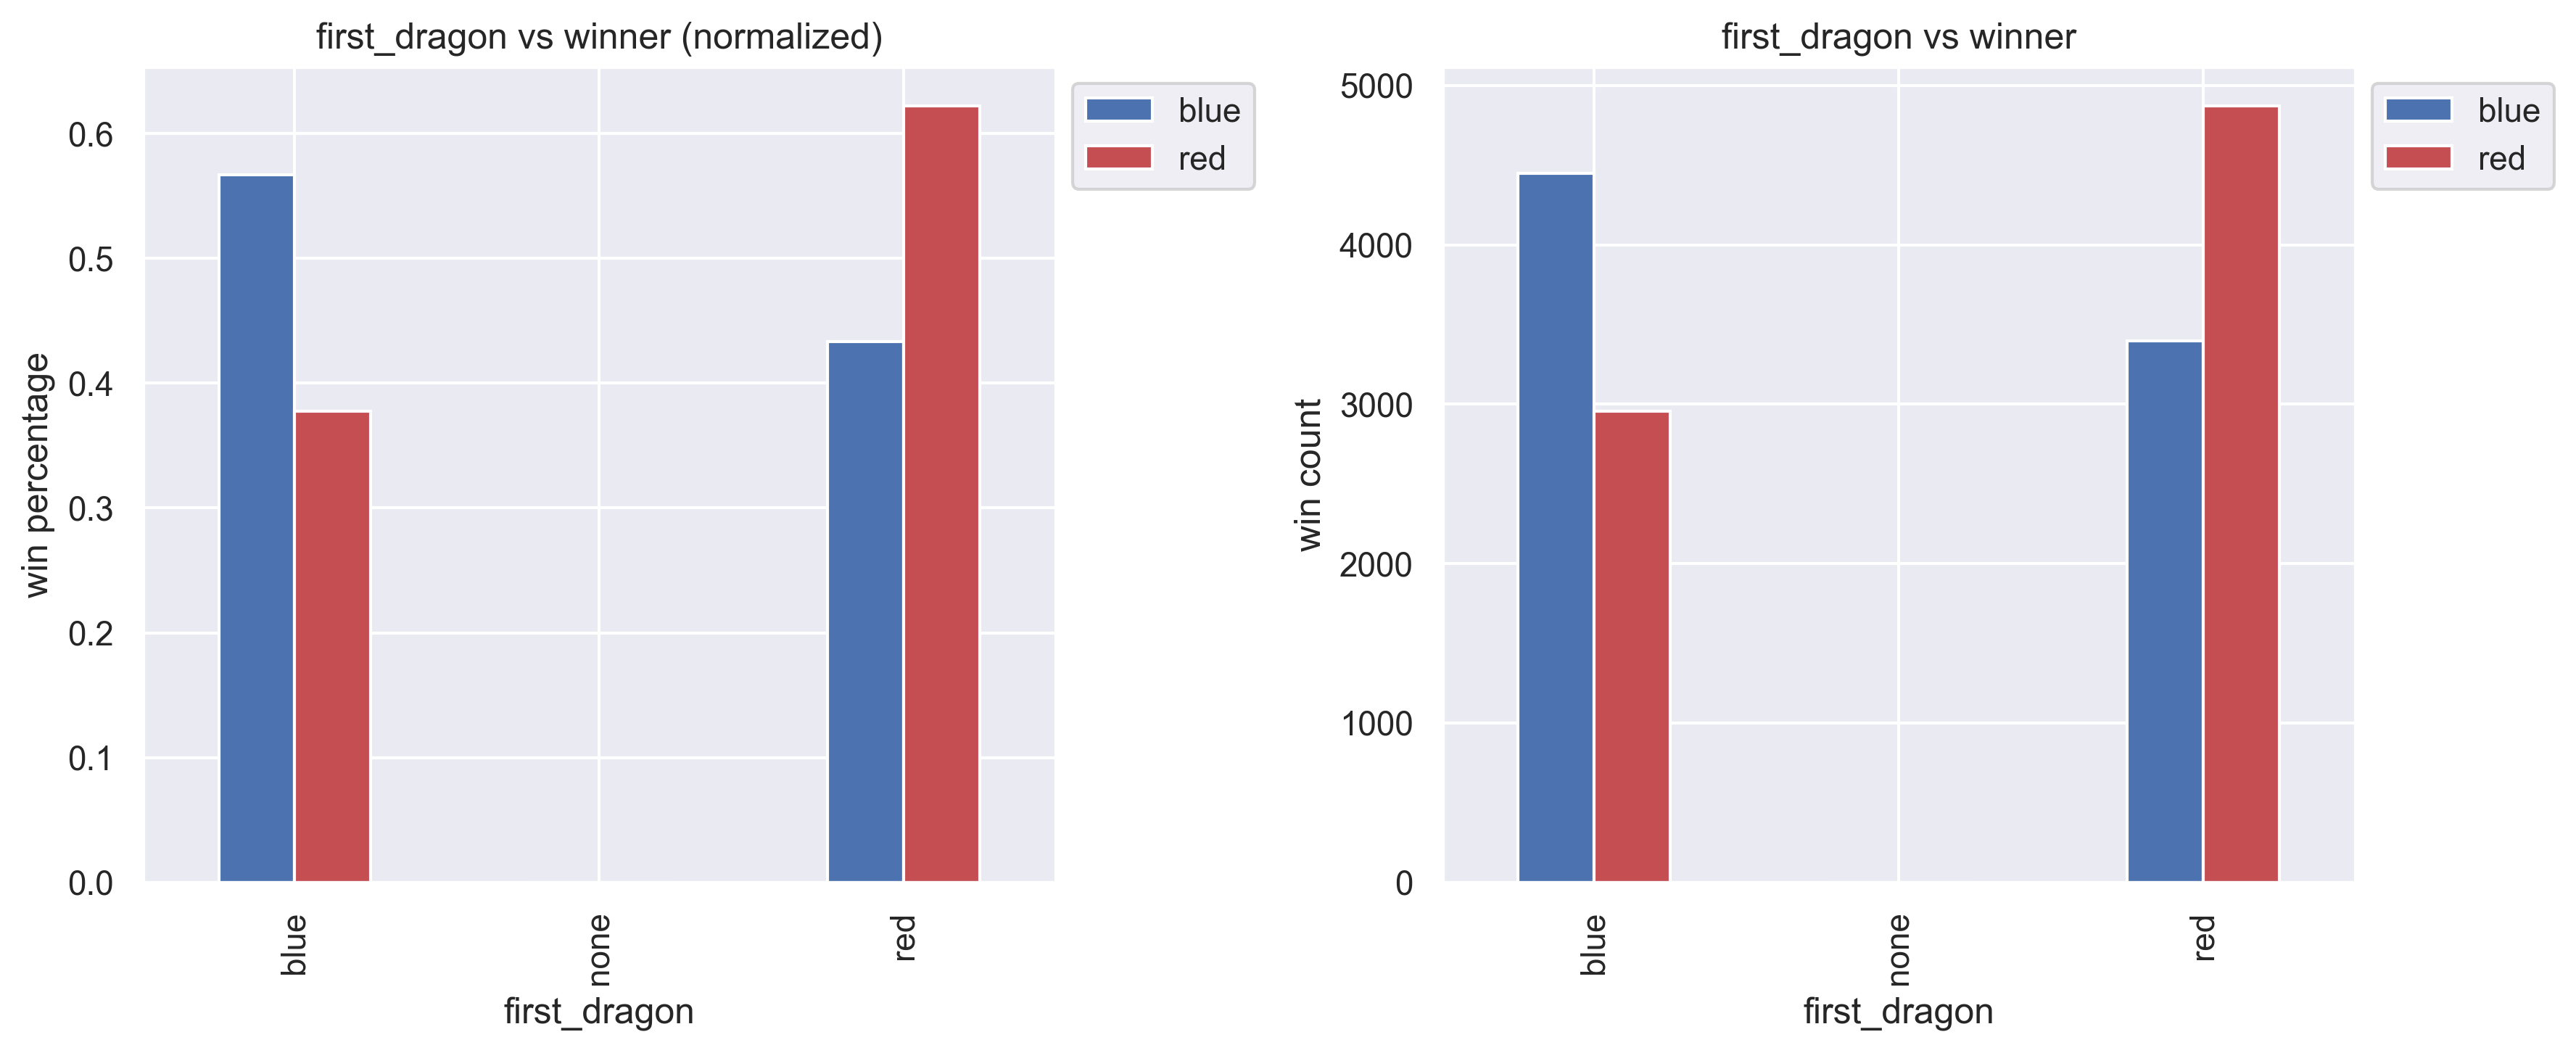

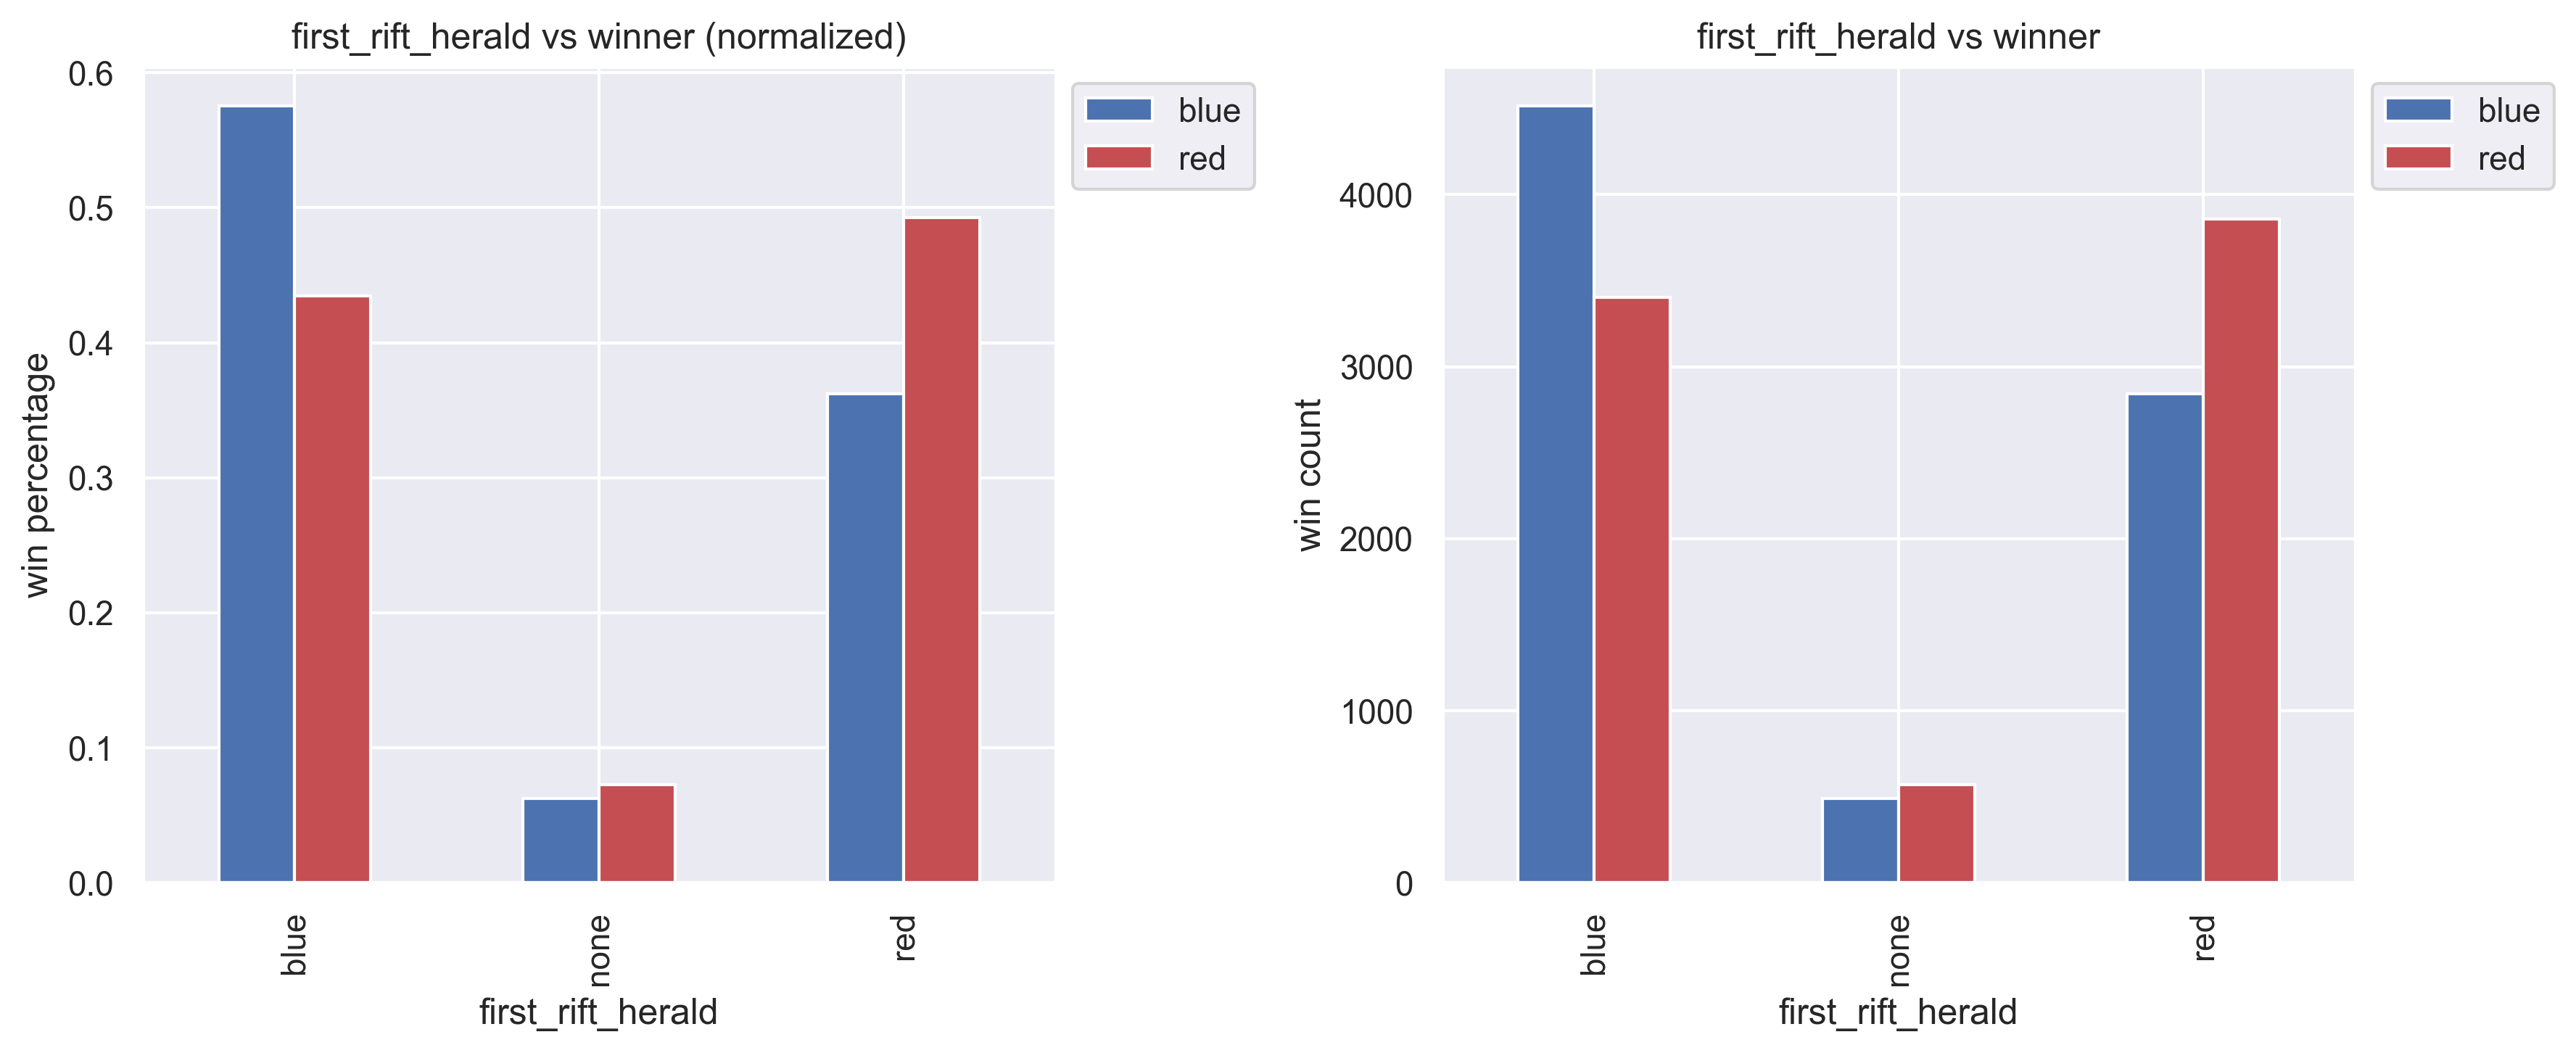

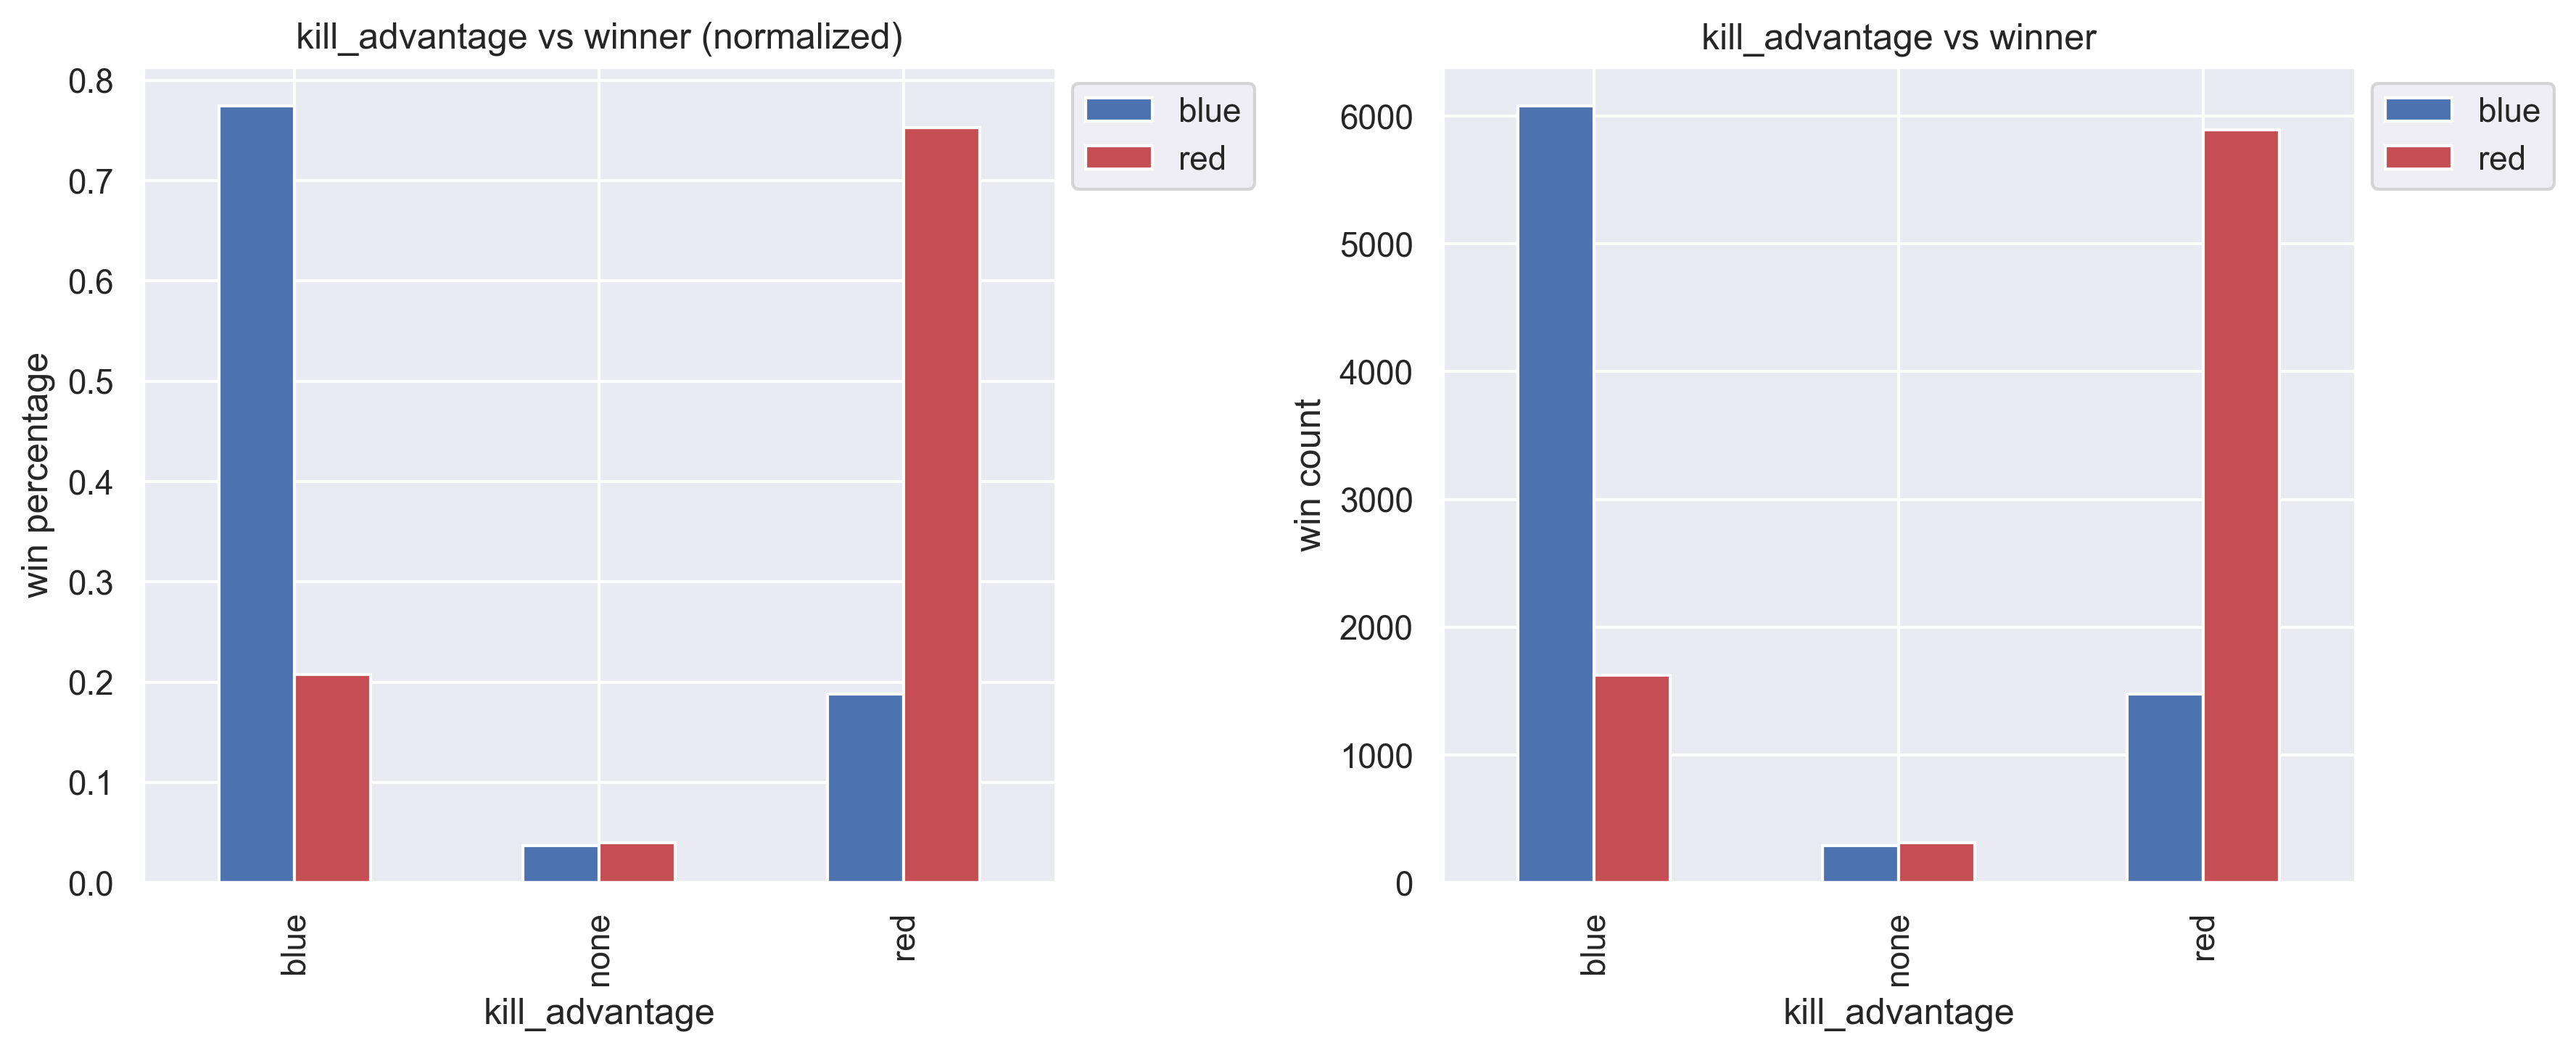

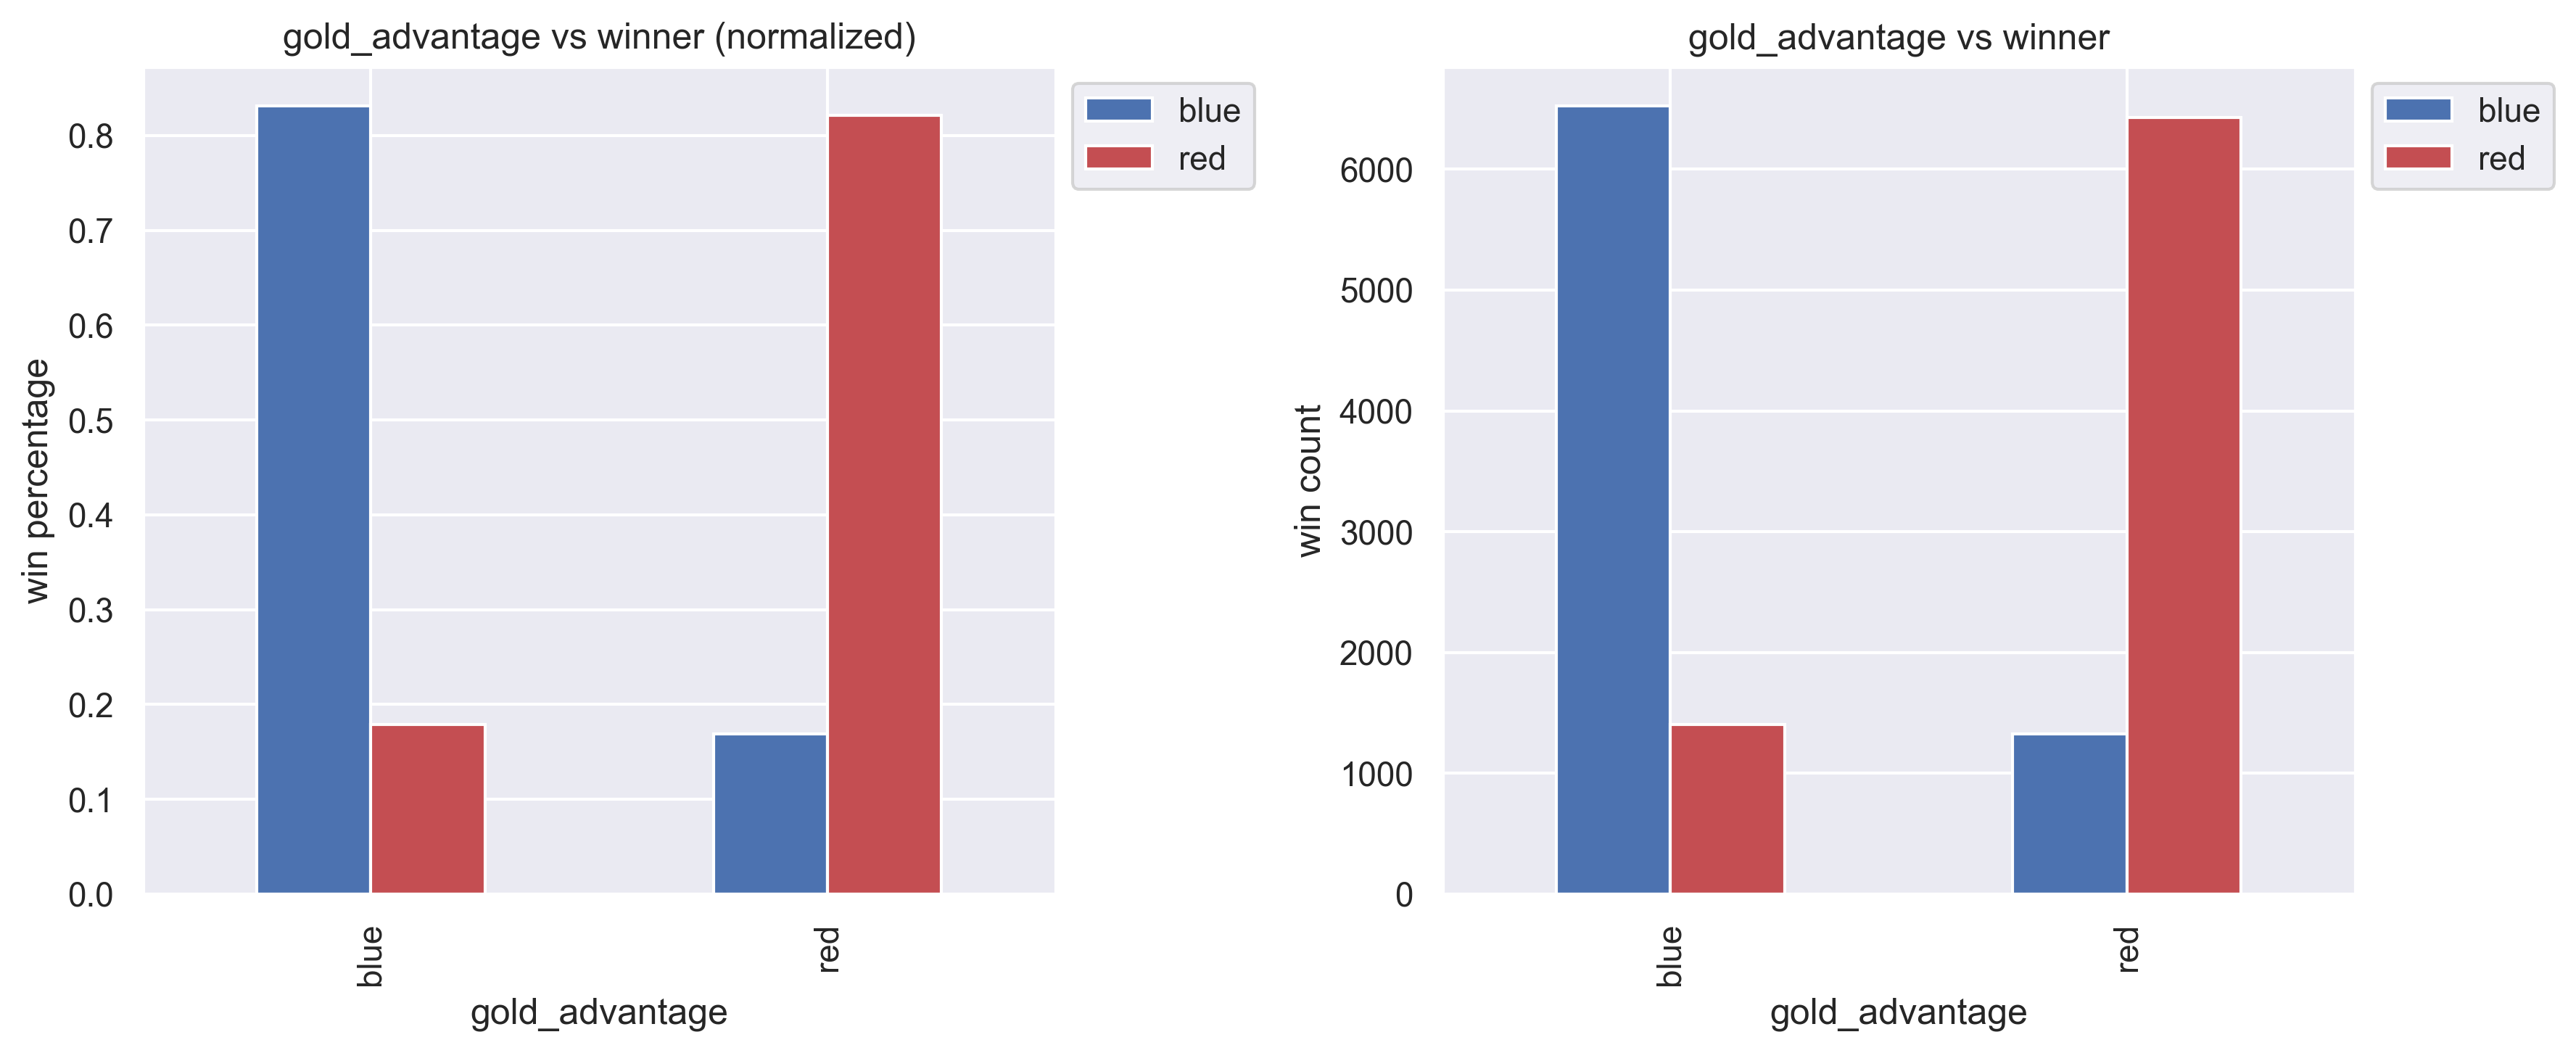

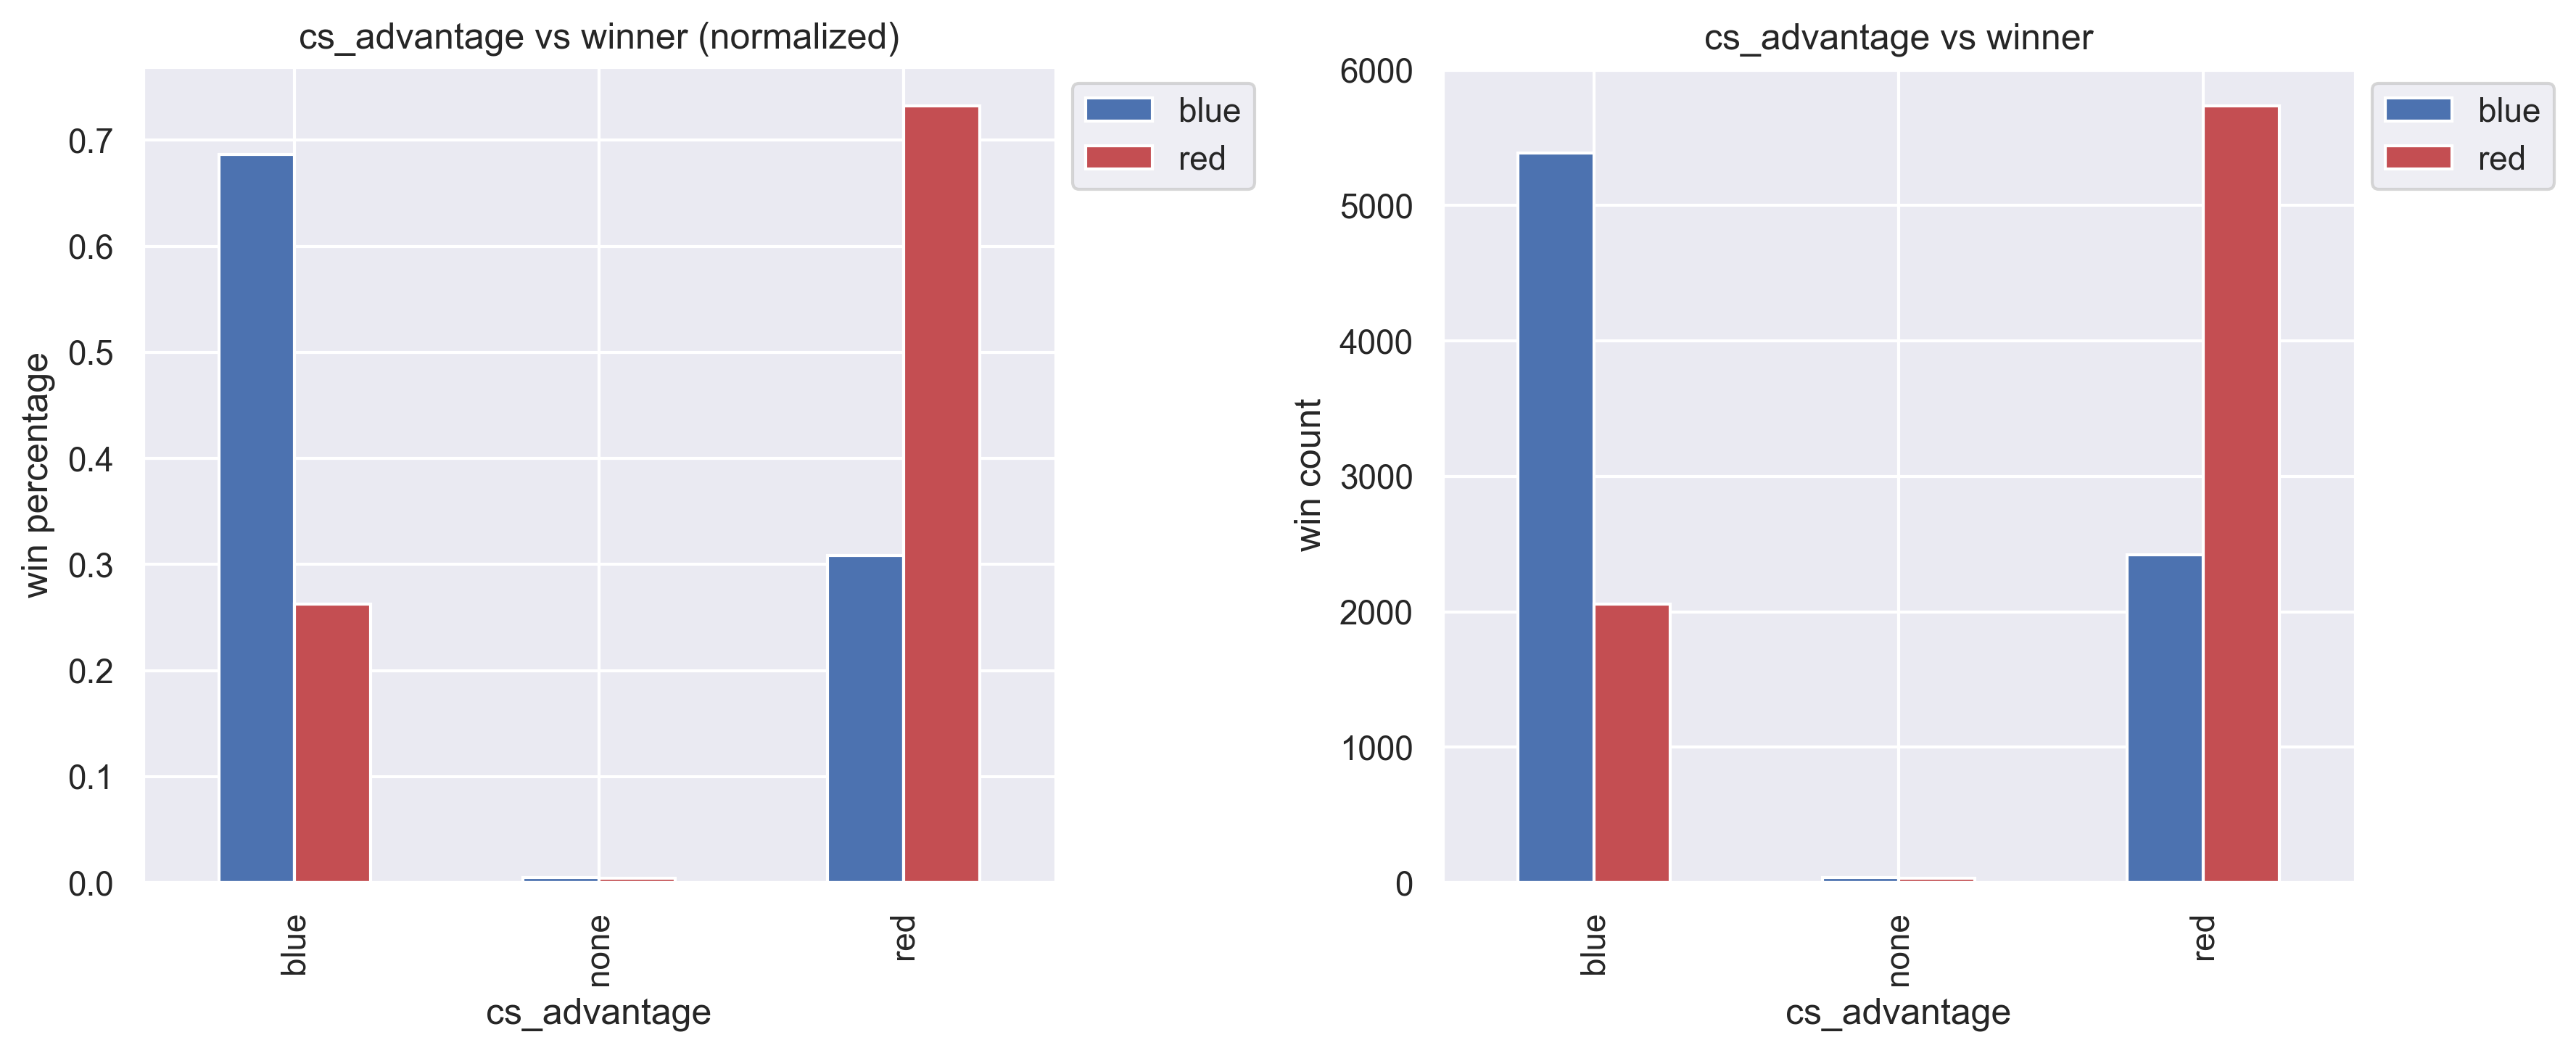

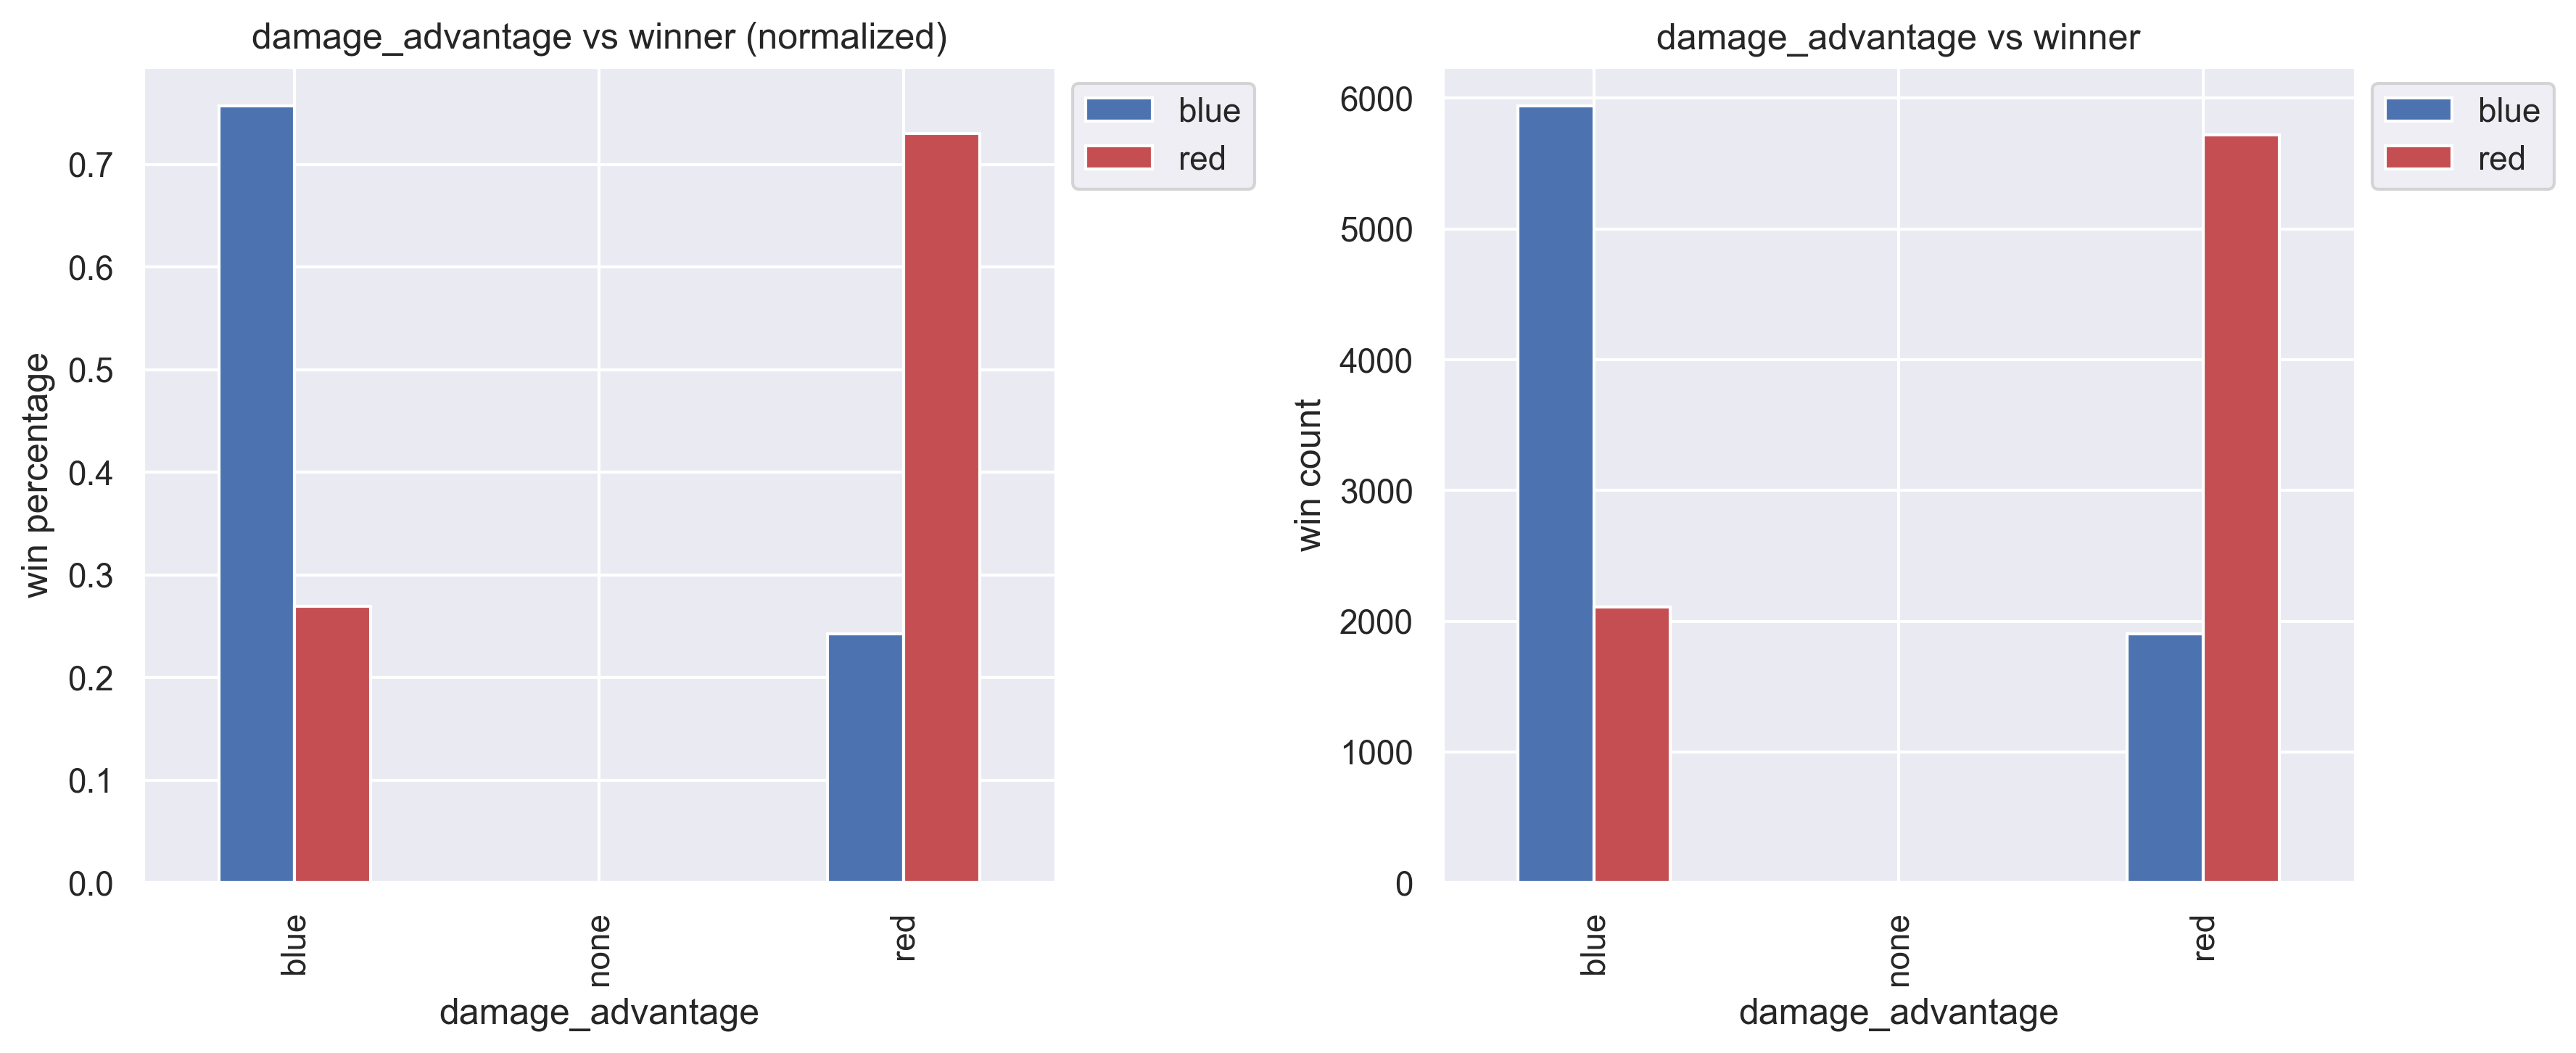

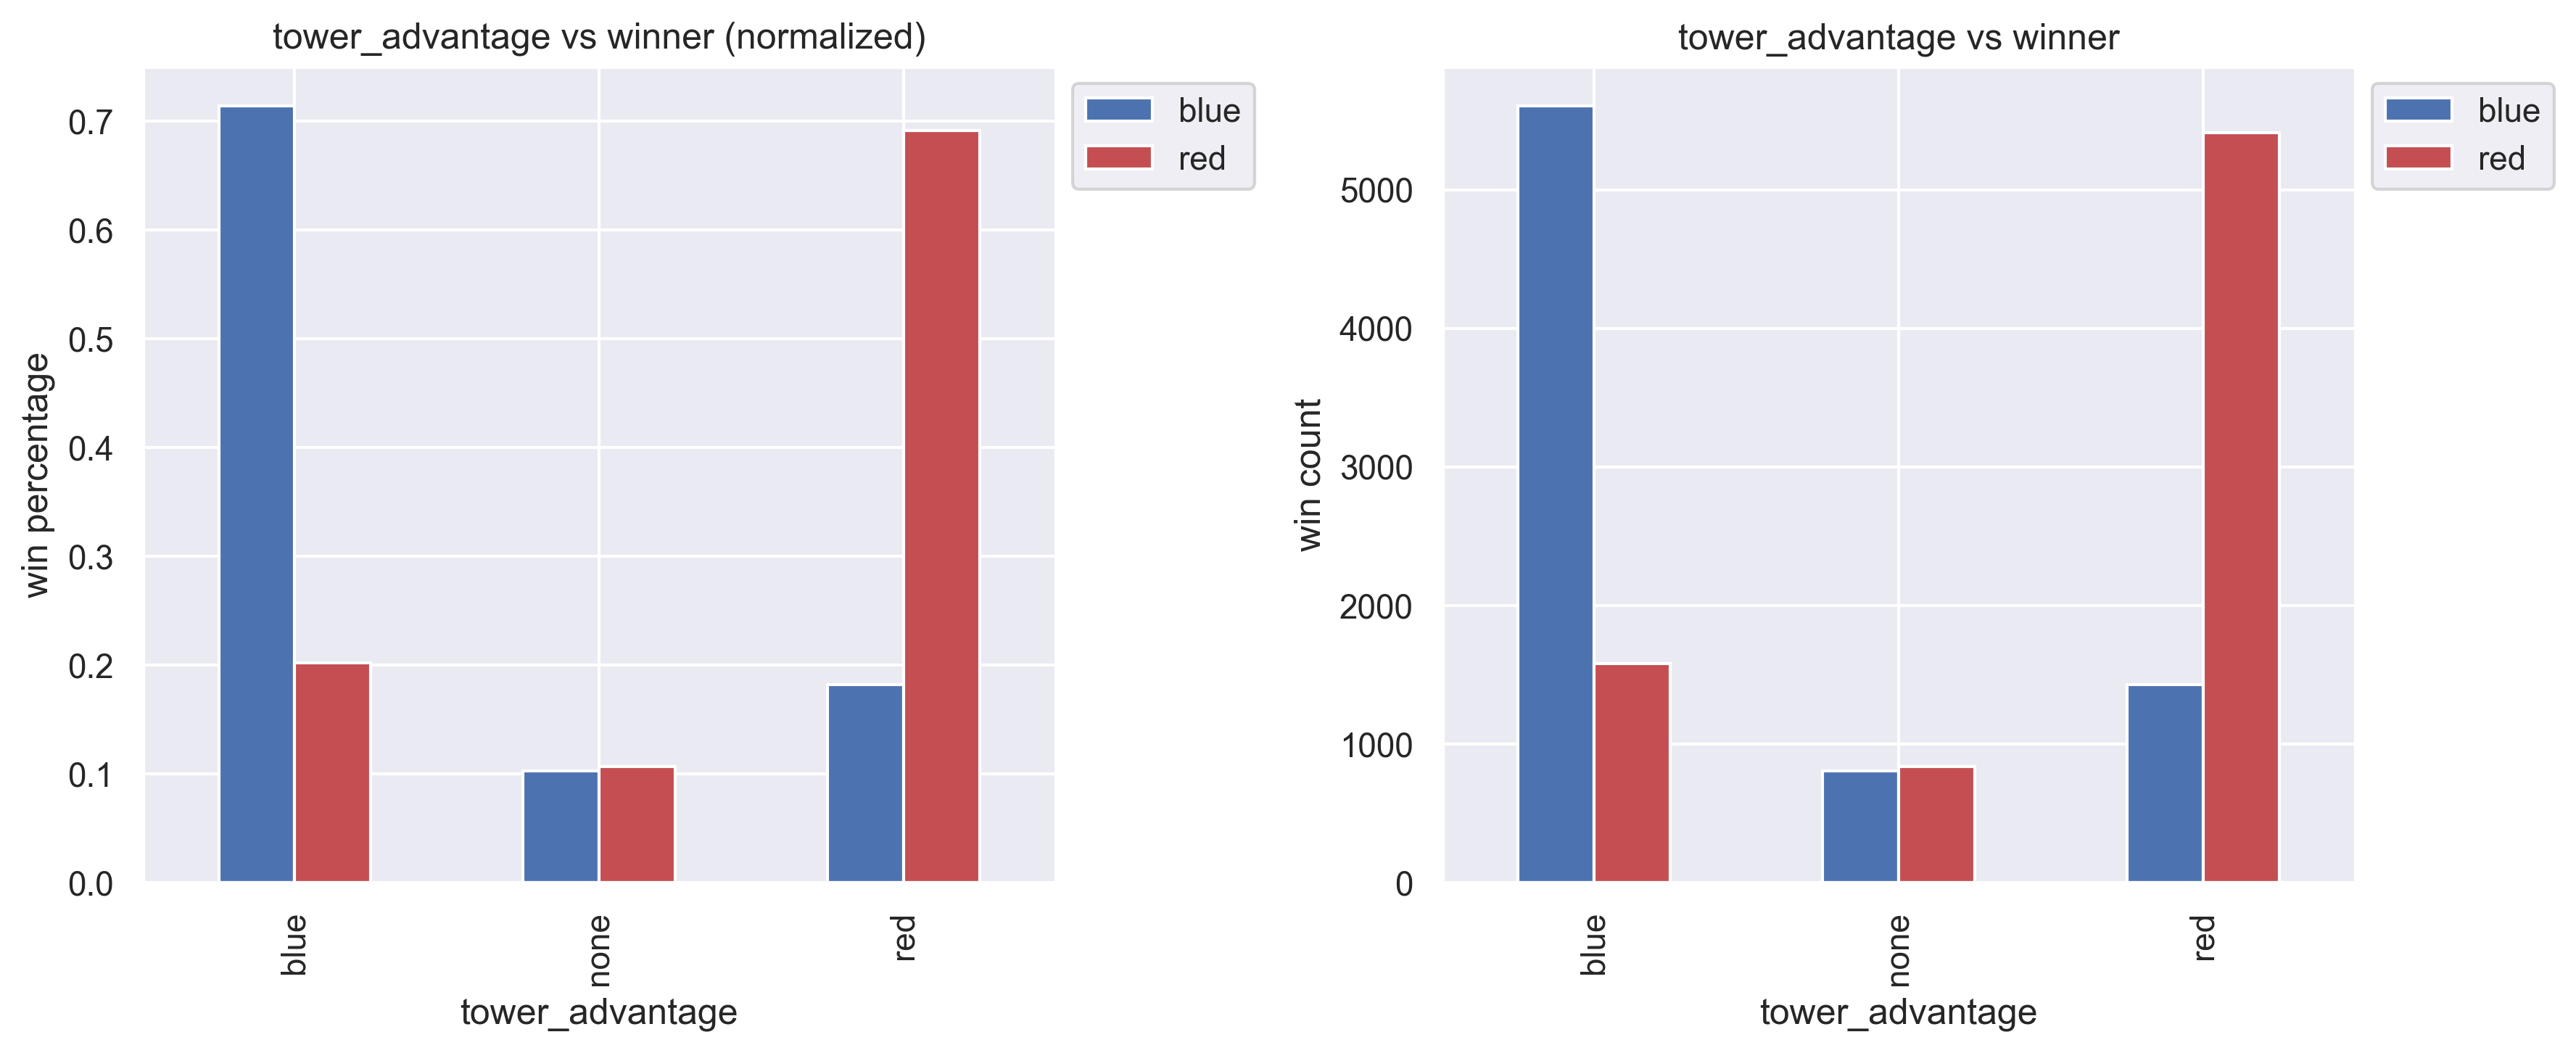

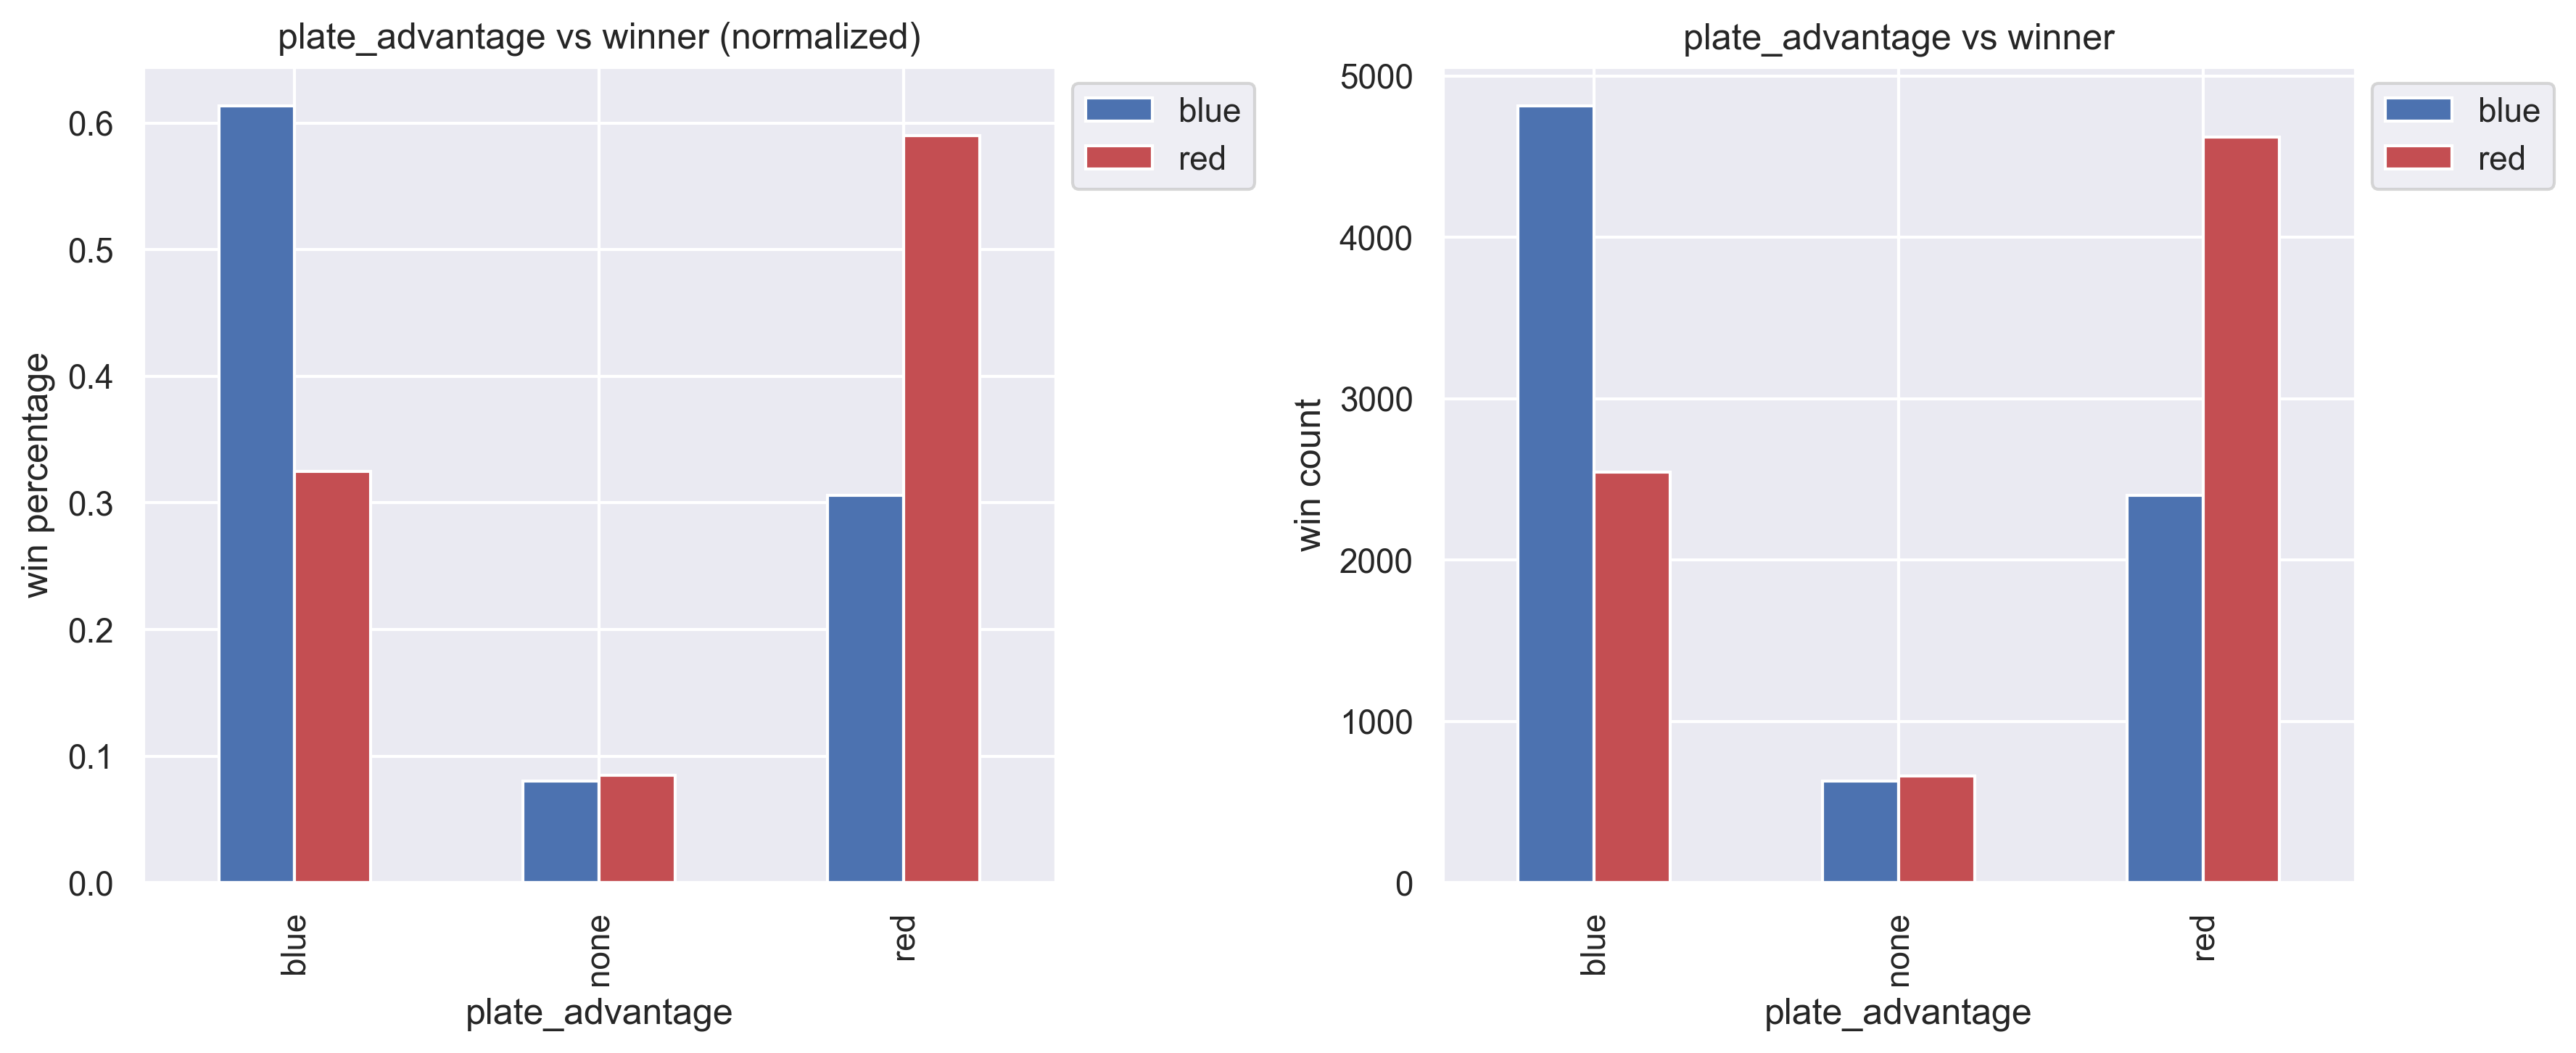

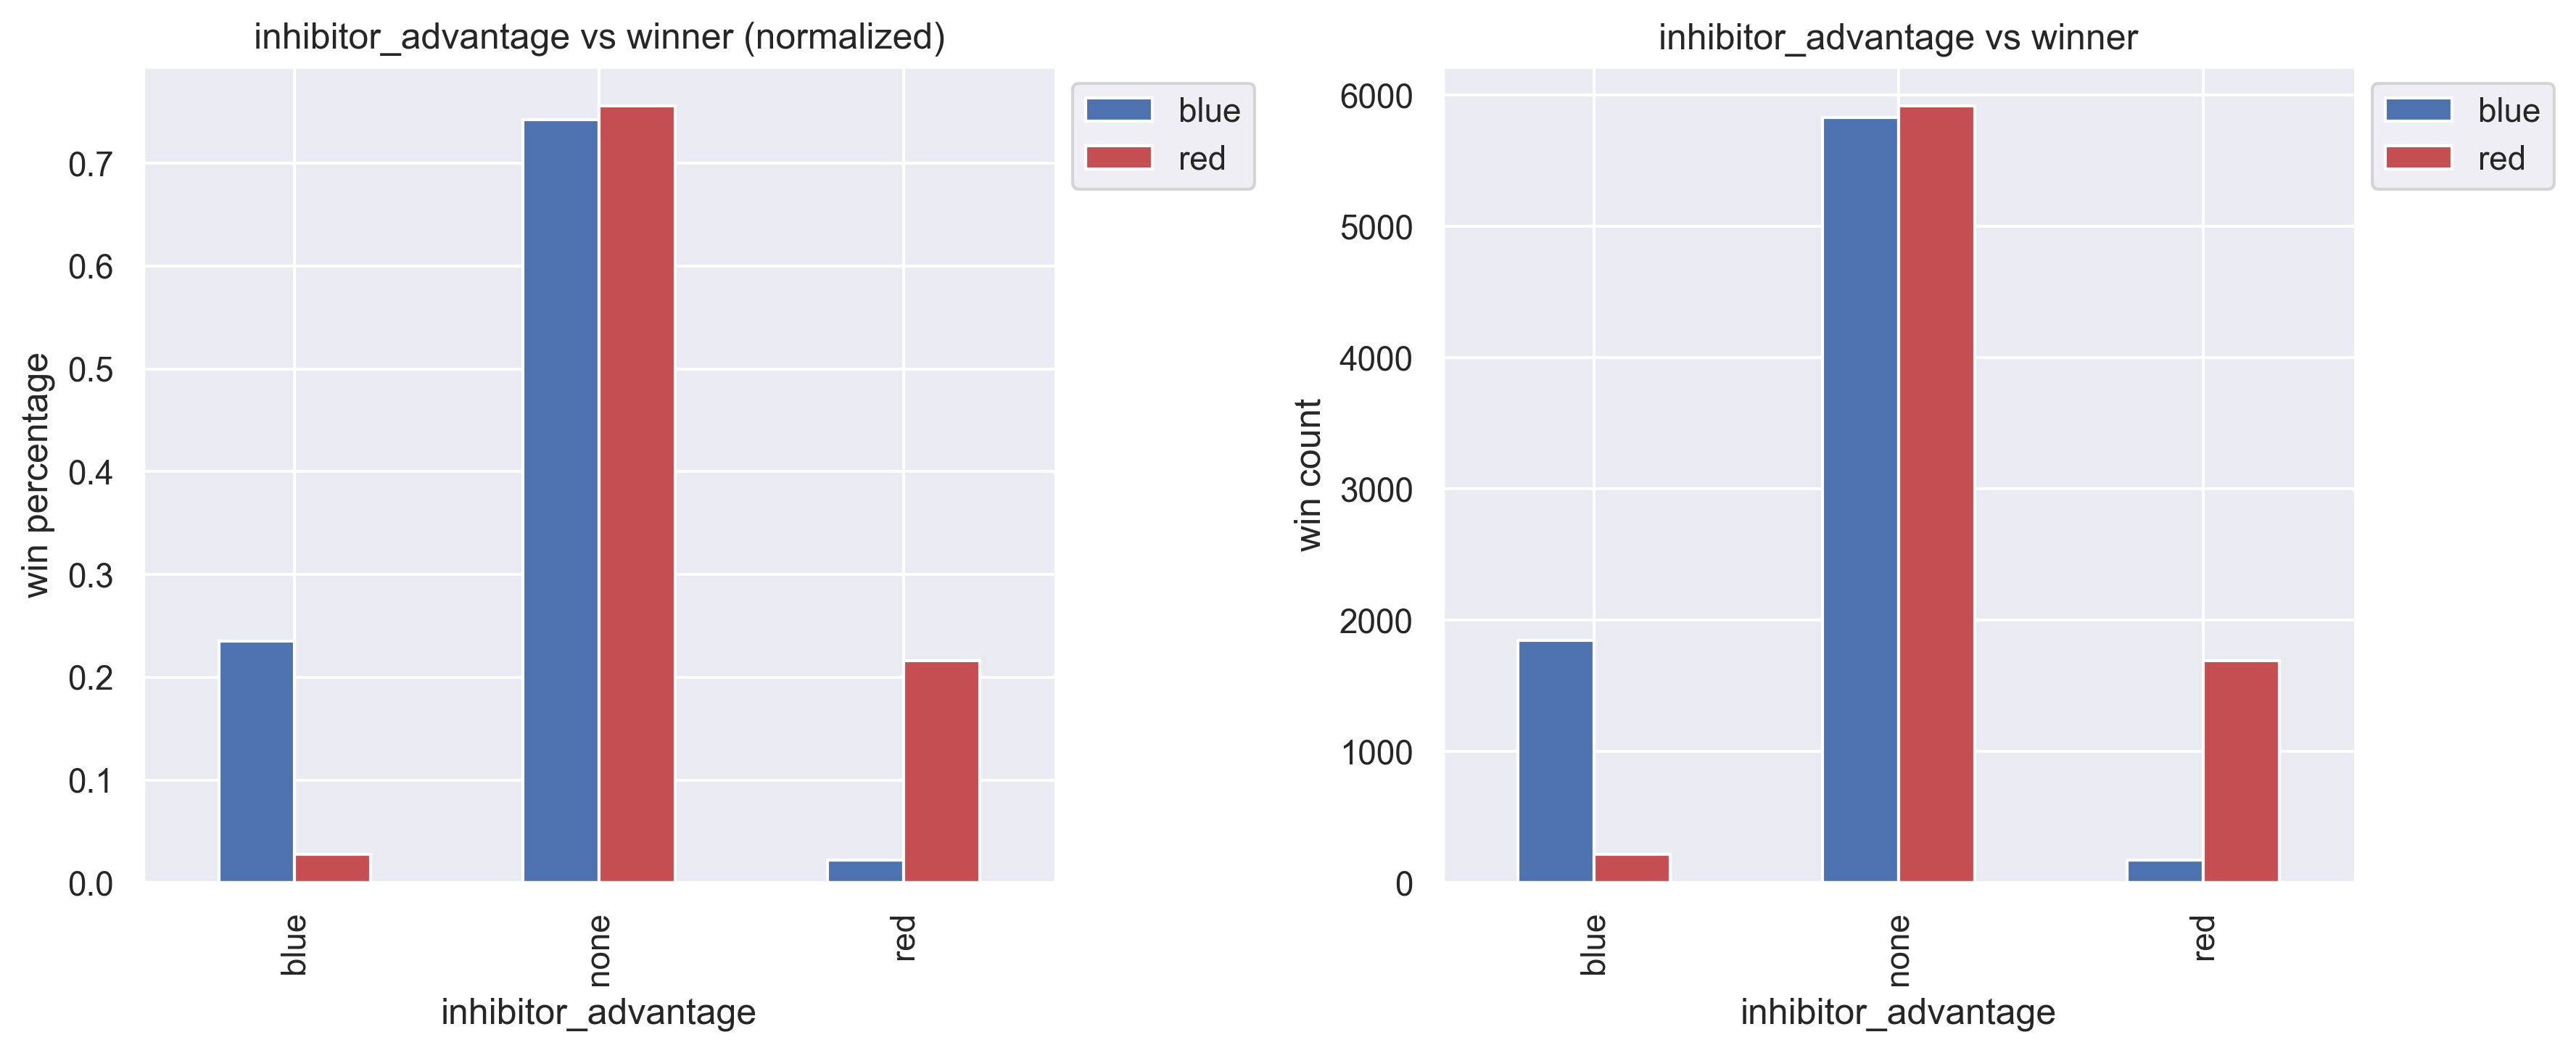

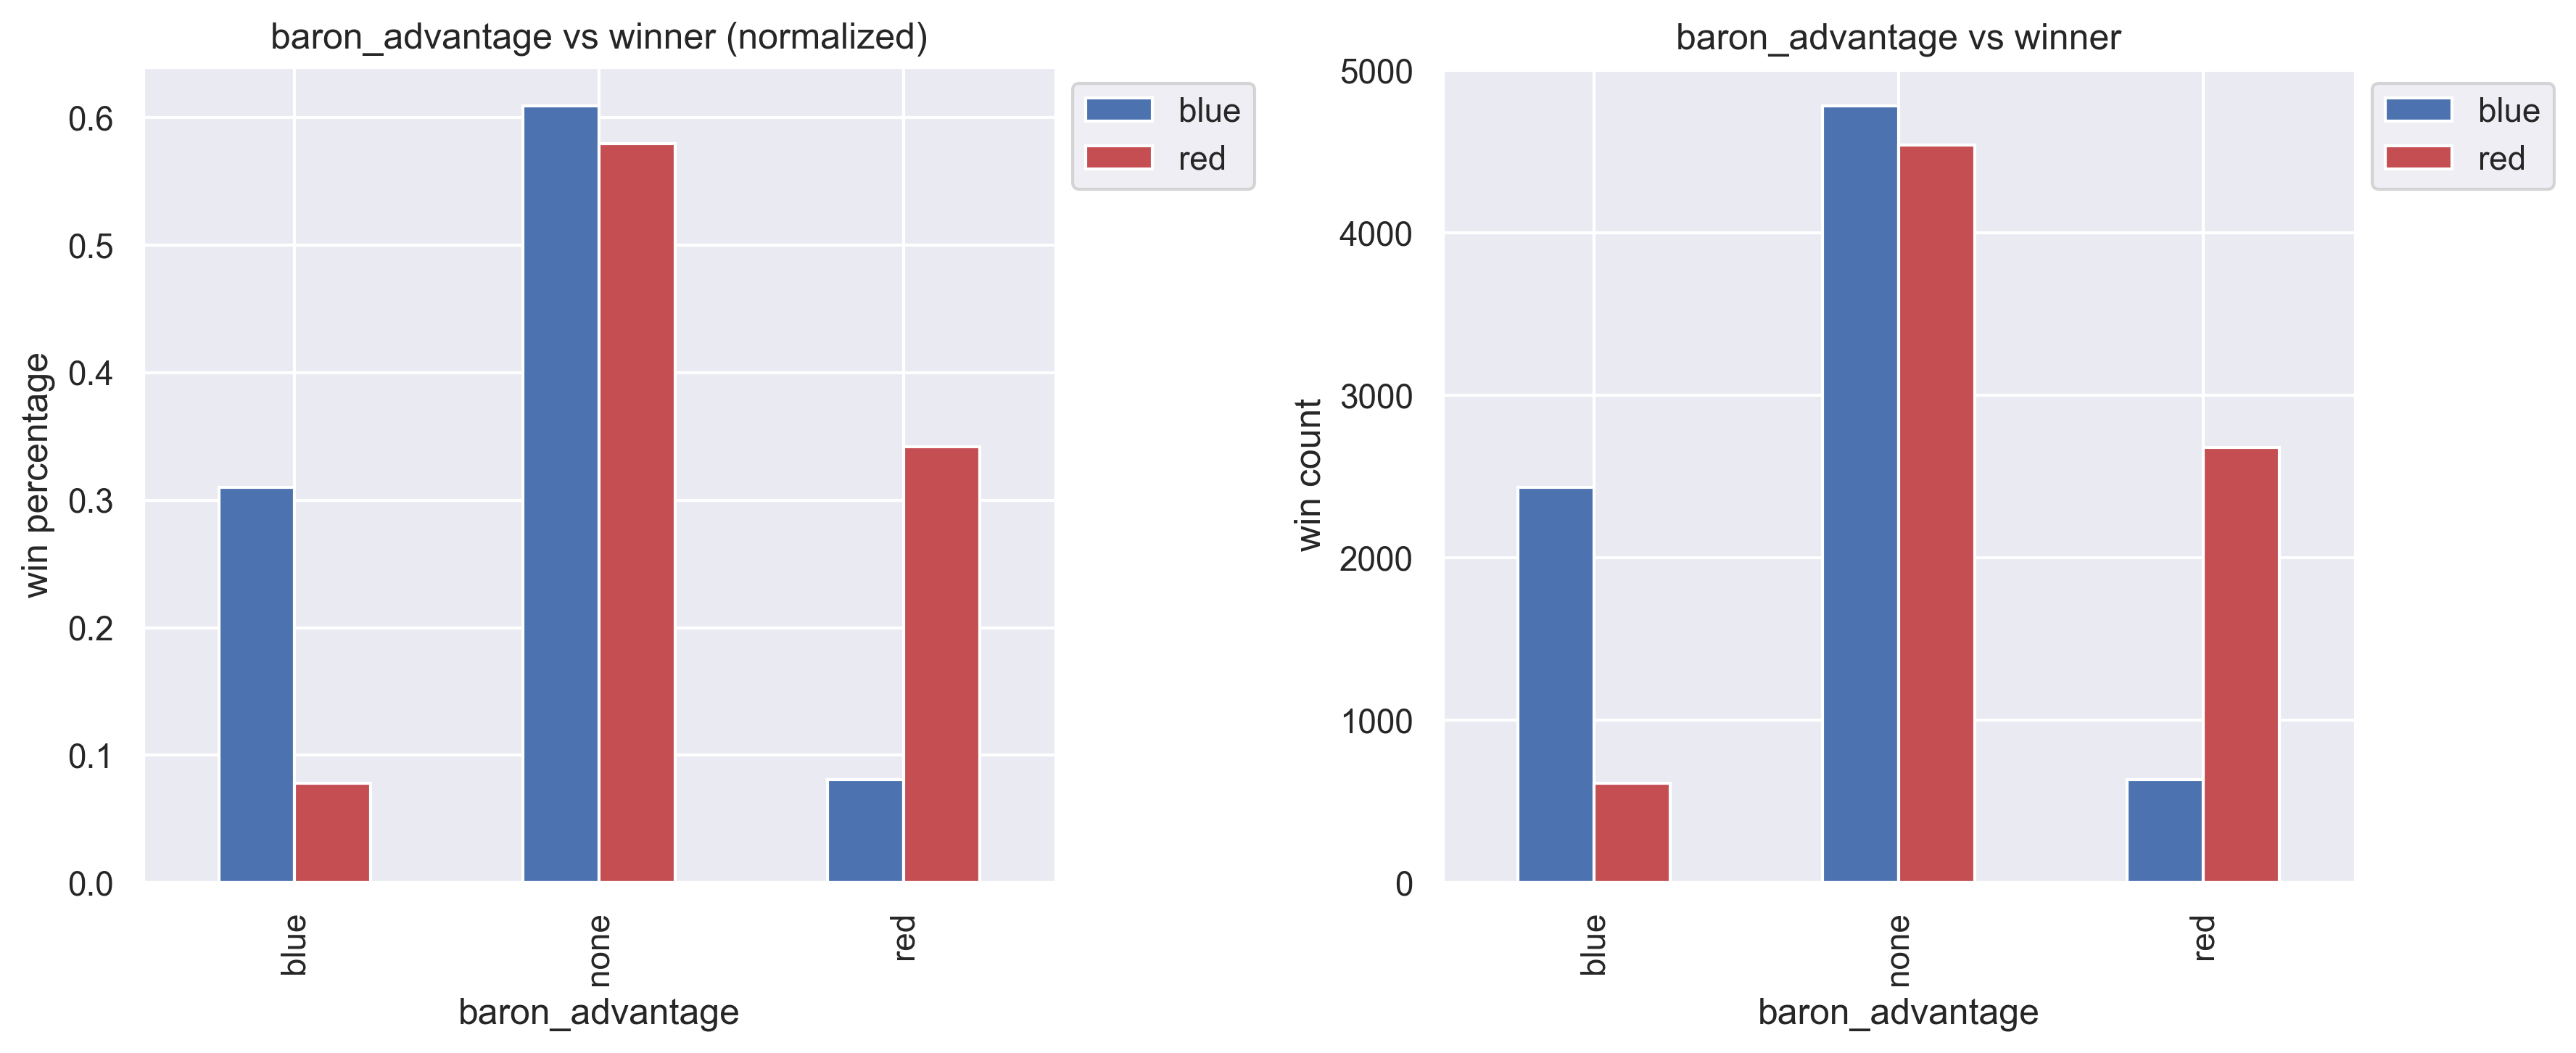

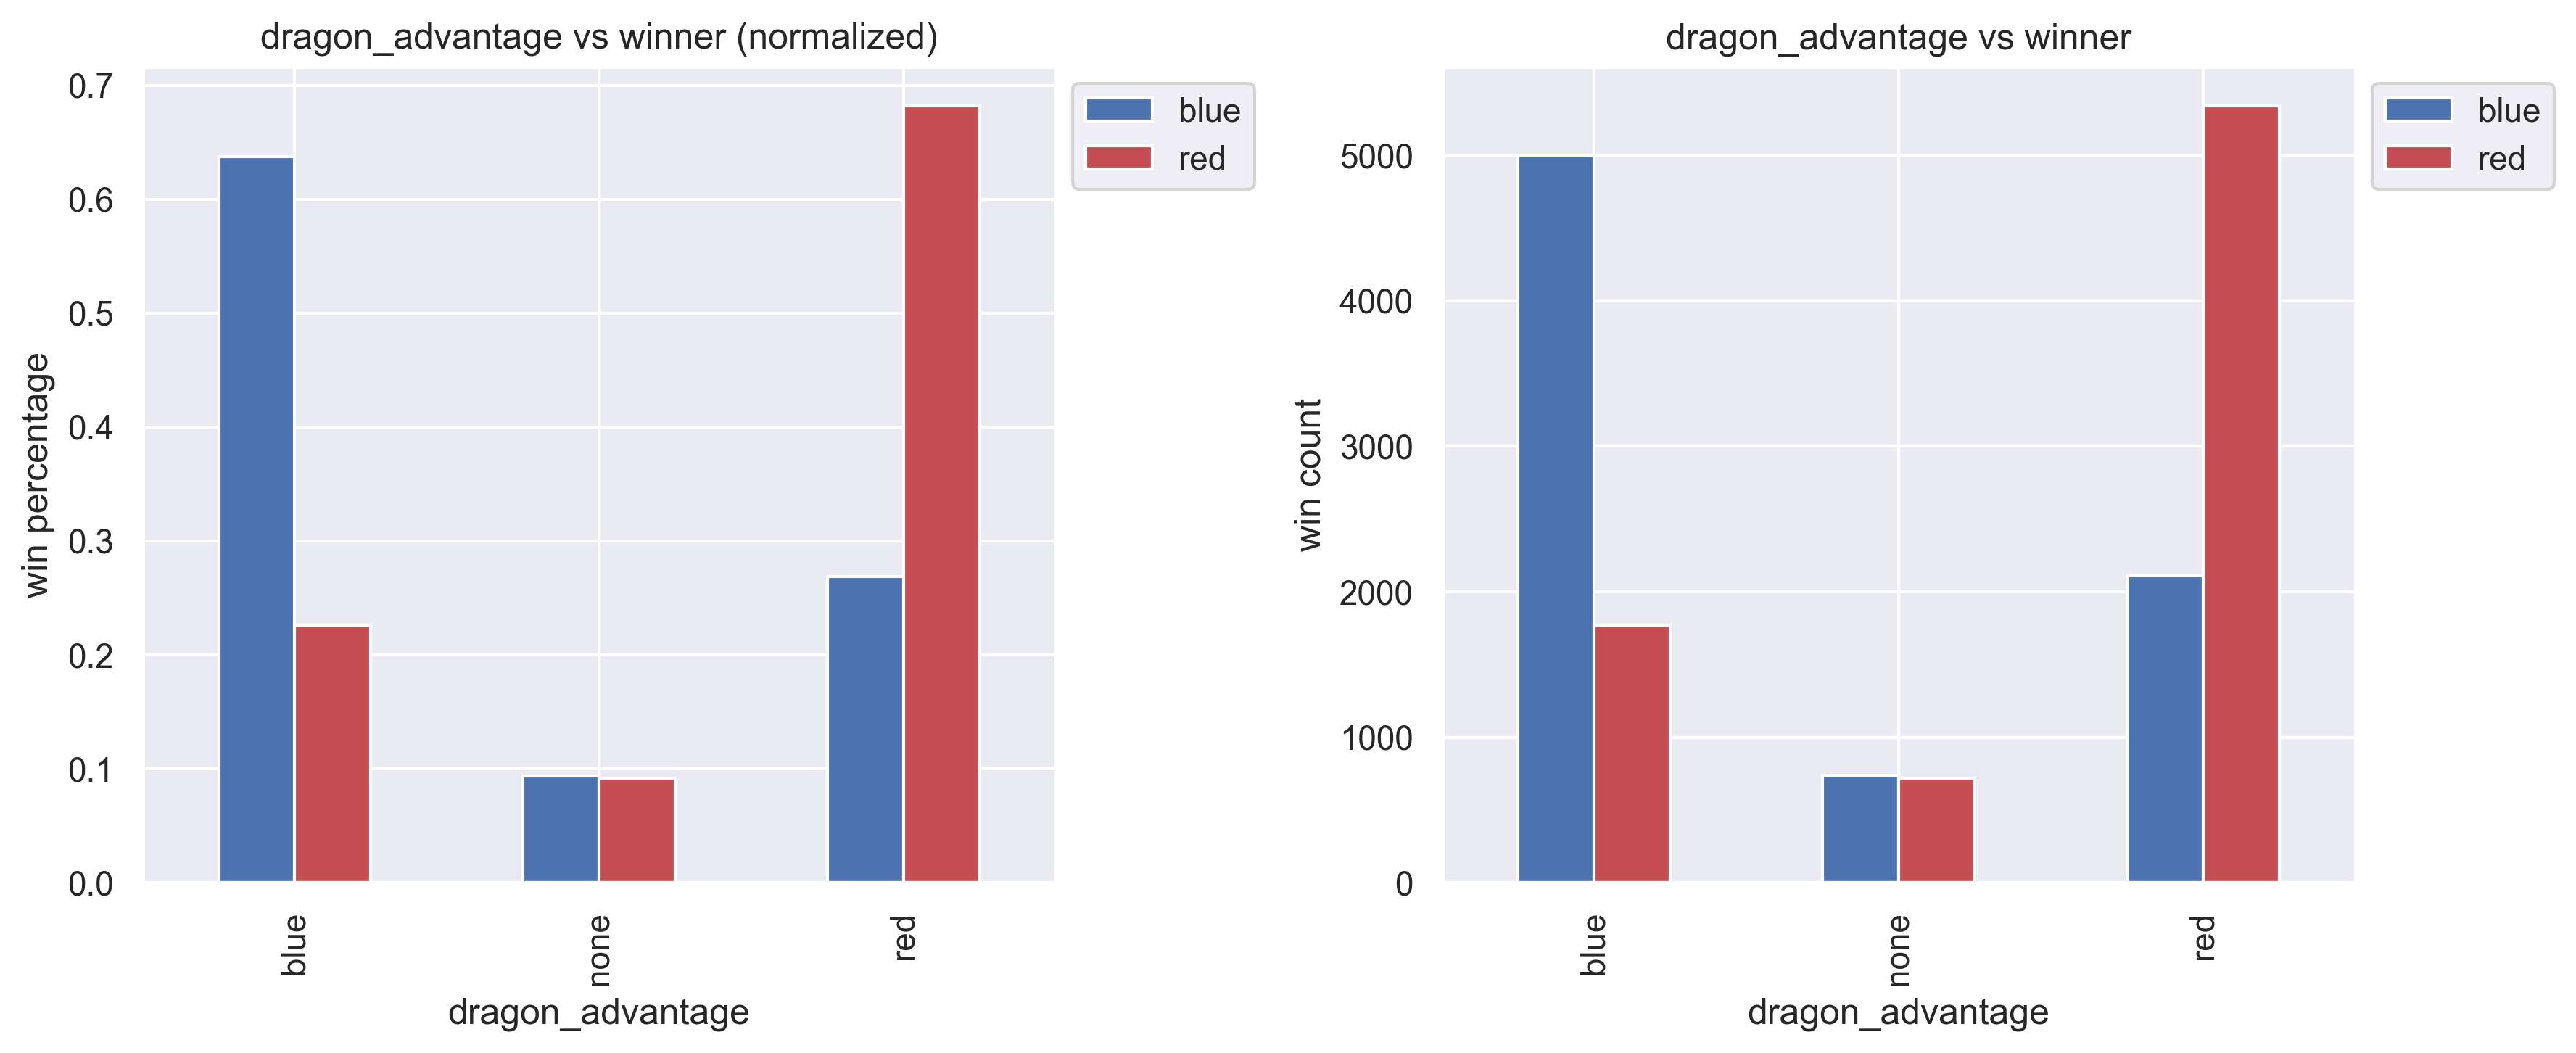

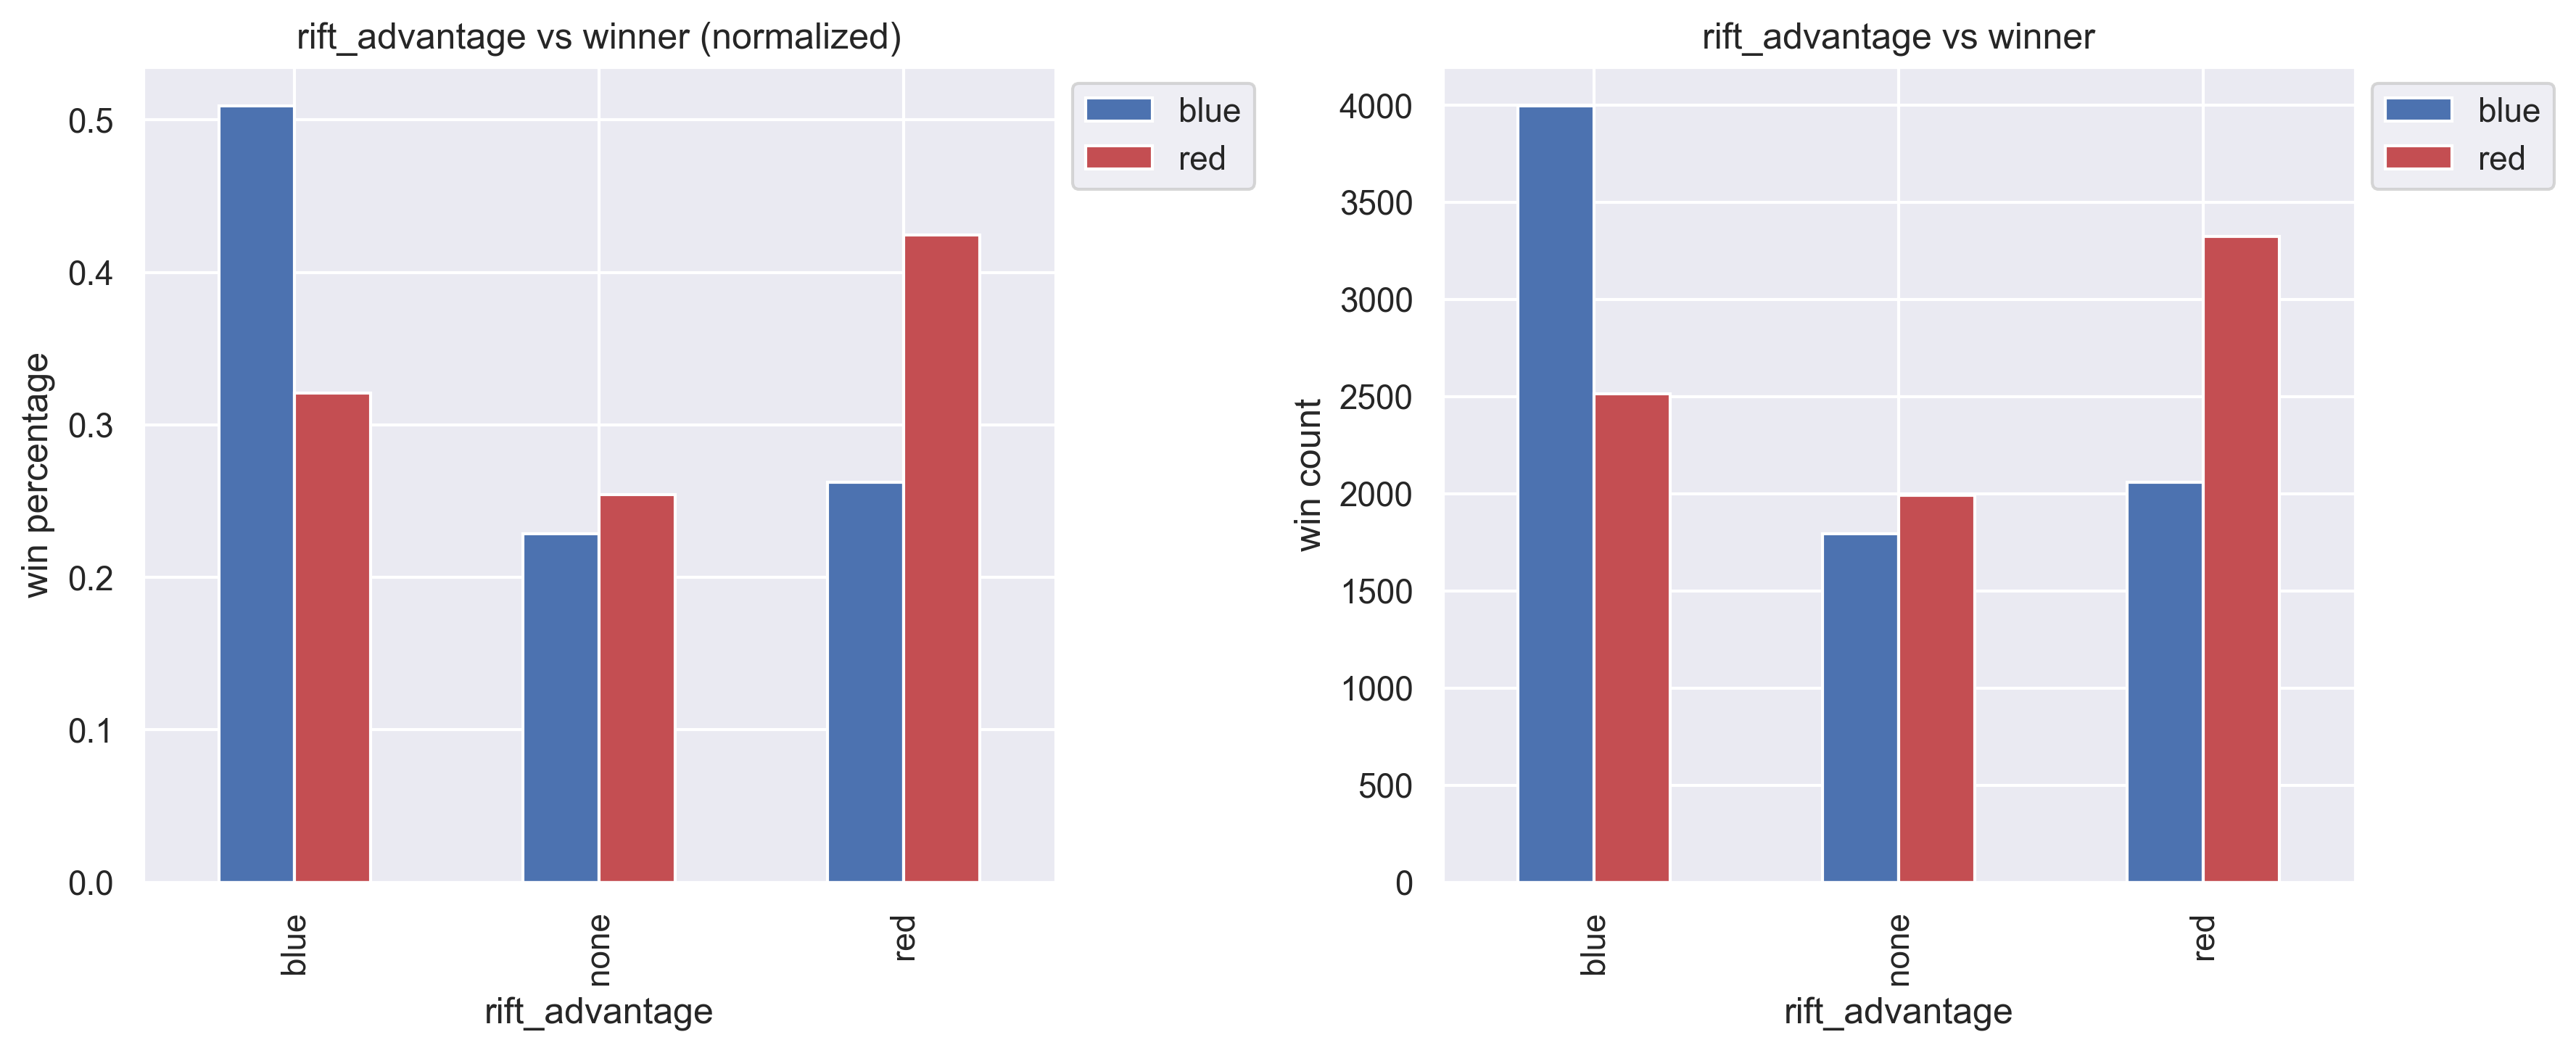

In [26]:
# plotting the pair wise correlation of each feature with class label
def plot_objective_first(df, f):
    fig = plt.figure(dpi=dpi, figsize=(12,5))
    pd.crosstab(df[f], df['winner'], normalize='columns').plot(
        kind='bar', color=['b', 'r'], title= f + ' vs winner (normalized)', ax=fig.add_subplot(121))
    plt.ylabel('win percentage')
    plt.legend(bbox_to_anchor = (1.0, 1.0), loc='upper left');
    # Plotting for normalized values
    pd.crosstab(df[f], df['winner']).plot(
        kind='bar', color=['b', 'r'], title= f + ' vs winner', ax=fig.add_subplot(122))
    plt.ylabel('win count')
    plt.legend(bbox_to_anchor = (1.0, 1.0), loc='upper left');
    plt.tight_layout()

plt_df = df_bi_trn.drop(columns=['tier']).replace({-1:'blue', 0:'none', 1:'red'})
for f in plt_df.drop(columns=['winner']):
    plot_objective_first(plt_df, f)

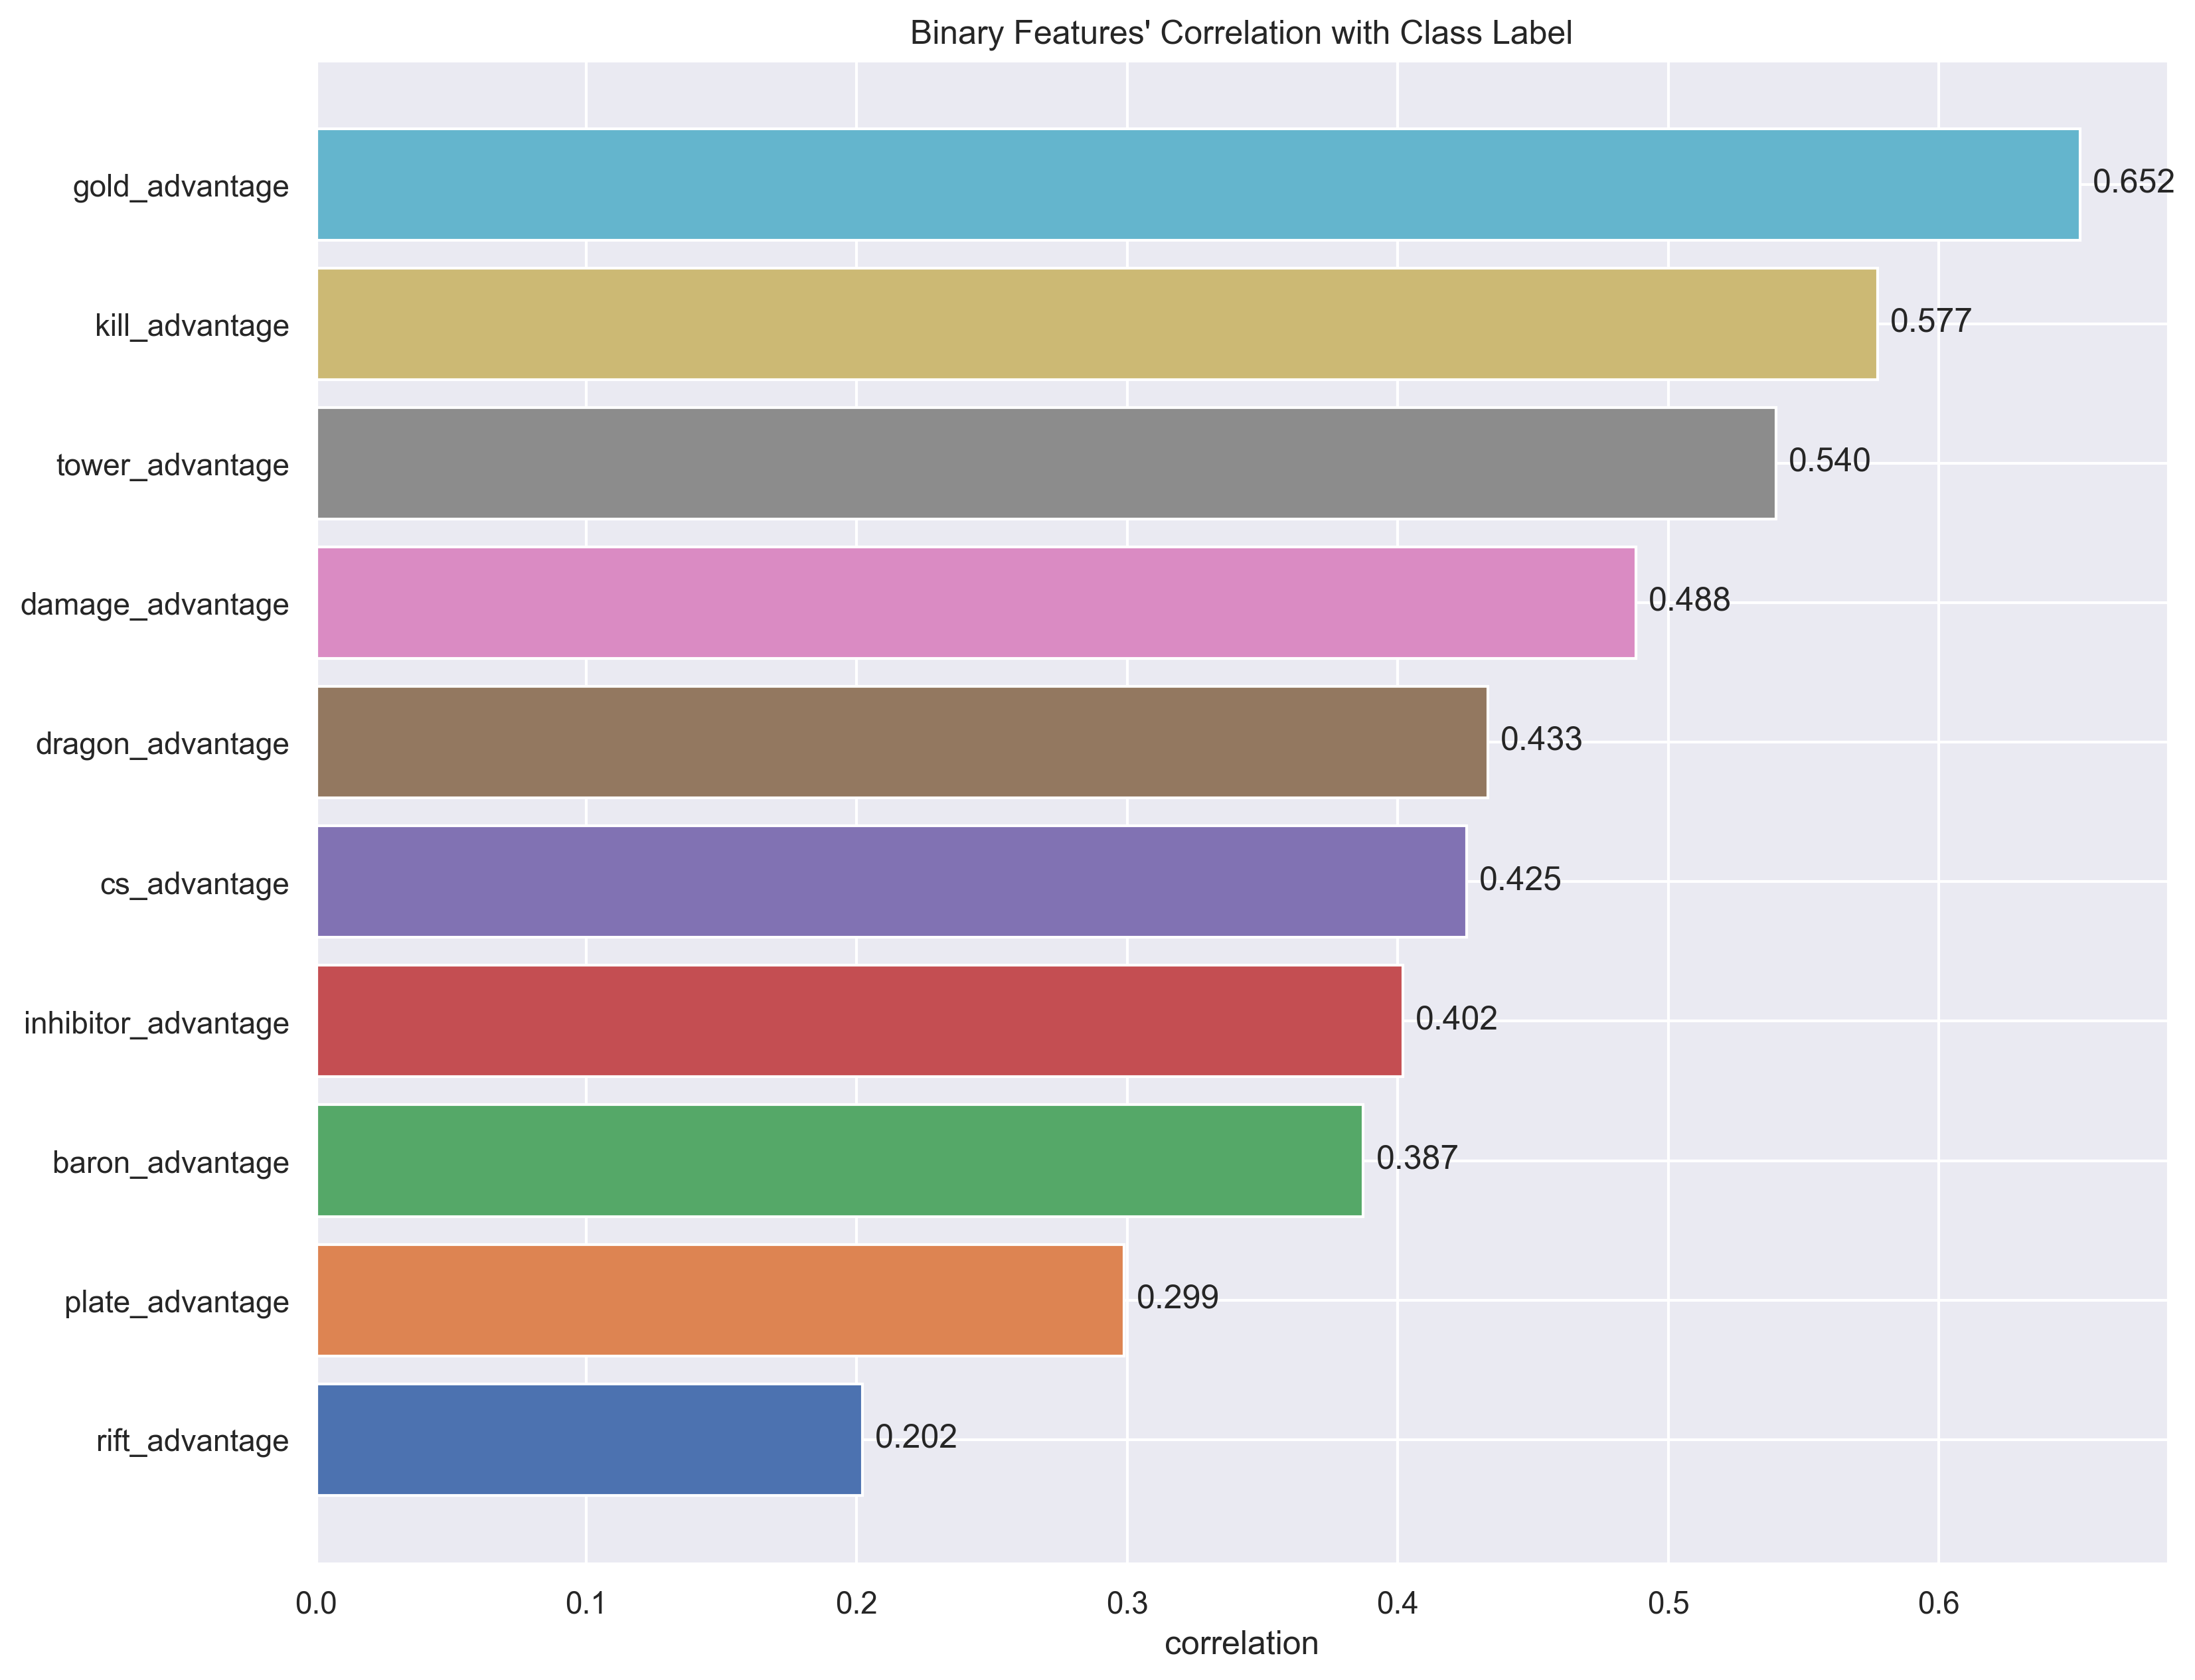

In [27]:
def plot_correlation_bar_plot(df, title):
    plt.figure(dpi=dpi, figsize=(12, 10))
    plot = plt.barh(df.sort_values().index.tolist(), df.sort_values(), color=sns.color_palette(as_cmap=True))
    plt.title(title)
    plt.xlabel('correlation');
    for bar in plot:
        width = bar.get_width() + 0.02
        plt.text(width, bar.get_y()+0.3, '%.3f' % bar.get_width(), ha='center', va='bottom')

# plotting the correlation of features' transformed using binary method with class label
plt_df = df_bi_trn.corr()['winner'].drop(['winner', 'first_kill', 'first_tower',
        'first_inhibitor', 'first_baron', 'first_dragon', 'first_rift_herald'])
plot_correlation_bar_plot(plt_df, title='Binary Features\' Correlation with Class Label')

### Difference Features

In [28]:
bronze = df_diff[df_diff['tier'] == 'BRONZE']
gold = df_diff[df_diff['tier'] == 'GOLD']
diamond = df_diff[df_diff['tier'] == 'DIAMOND']
gm = df_diff[df_diff['tier'] == 'GRANDMASTERS']
bronze_trn, bronze_tst = sklearn.model_selection.train_test_split(bronze, train_size=0.8, test_size=0.2,
                            random_state=random_state, stratify=bronze['winner'])
gold_trn, gold_tst = sklearn.model_selection.train_test_split(gold, train_size=0.8, test_size=0.2,
                            random_state=random_state, stratify=gold['winner'])
diamond_trn, diamond_tst = sklearn.model_selection.train_test_split(diamond, train_size=0.8, test_size=0.2,
                            random_state=random_state, stratify=diamond['winner'])
gm_trn, gm_tst = sklearn.model_selection.train_test_split(gm, train_size=0.8, test_size=0.2,
                            random_state=random_state, stratify=gm['winner'])
df_diff_trn = bronze_trn.append([gold_trn, diamond_trn, gm_trn])
df_diff_tst = bronze_tst.append([gold_tst, diamond_tst, gm_tst])

In [29]:
print('Number of data points in training set: ' + str(df_diff_trn.shape[0]) +
      '\nNumber of data points in test set: ' + str(df_diff_tst.shape[0]) +
      '\nClass distribution in training data:\nBlue:' + '%.2f%%' % ((df_diff_trn.groupby('winner').size().tolist()[0]/df_diff_trn .shape[0])*100)
      + '\nRed:' + '%.2f%%' % ((df_diff_trn .groupby('winner').size().tolist()[1]/df_diff_trn.shape[0])*100))

Number of data points in training set: 15680
Number of data points in test set: 3920
Class distribution in training data:
Blue:50.06%
Red:49.94%


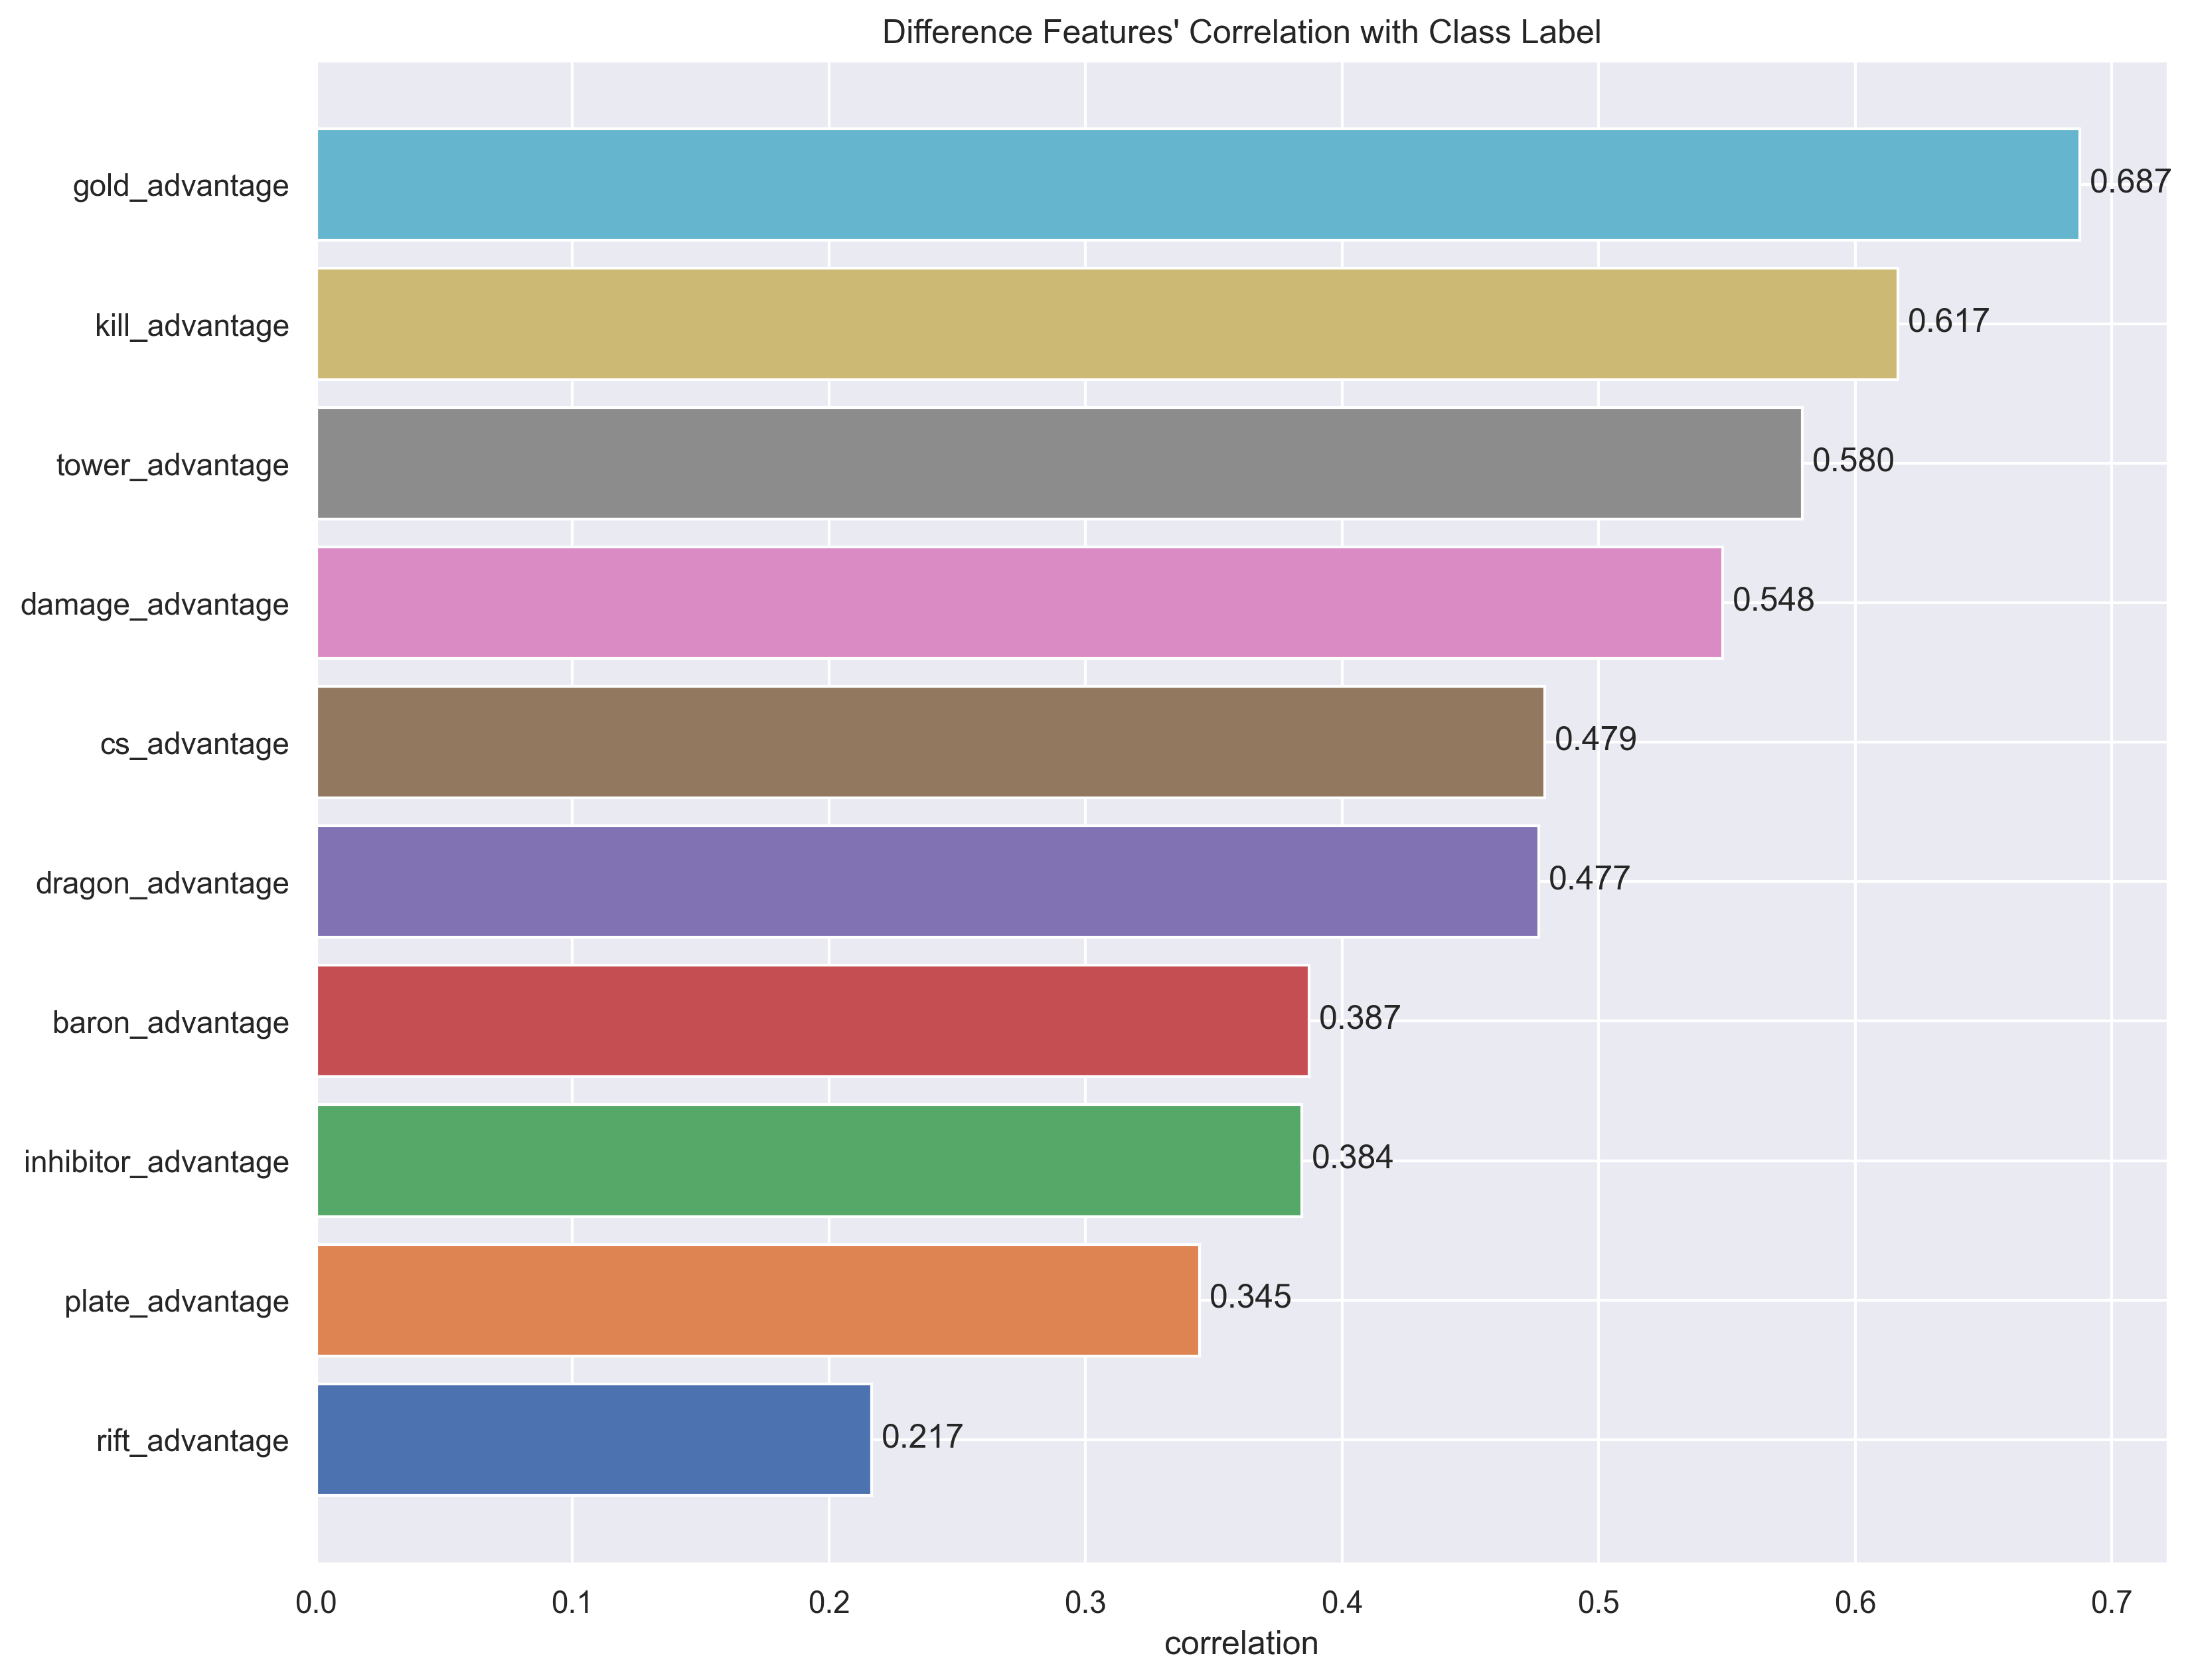

In [30]:
# plotting the correlation of features' transformed using difference method with class label
plt_df = df_diff_trn.corr()['winner'].drop(['winner', 'first_kill', 'first_tower',
        'first_inhibitor', 'first_baron', 'first_dragon', 'first_rift_herald'])
plot_correlation_bar_plot(plt_df, title='Difference Features\' Correlation with Class Label')

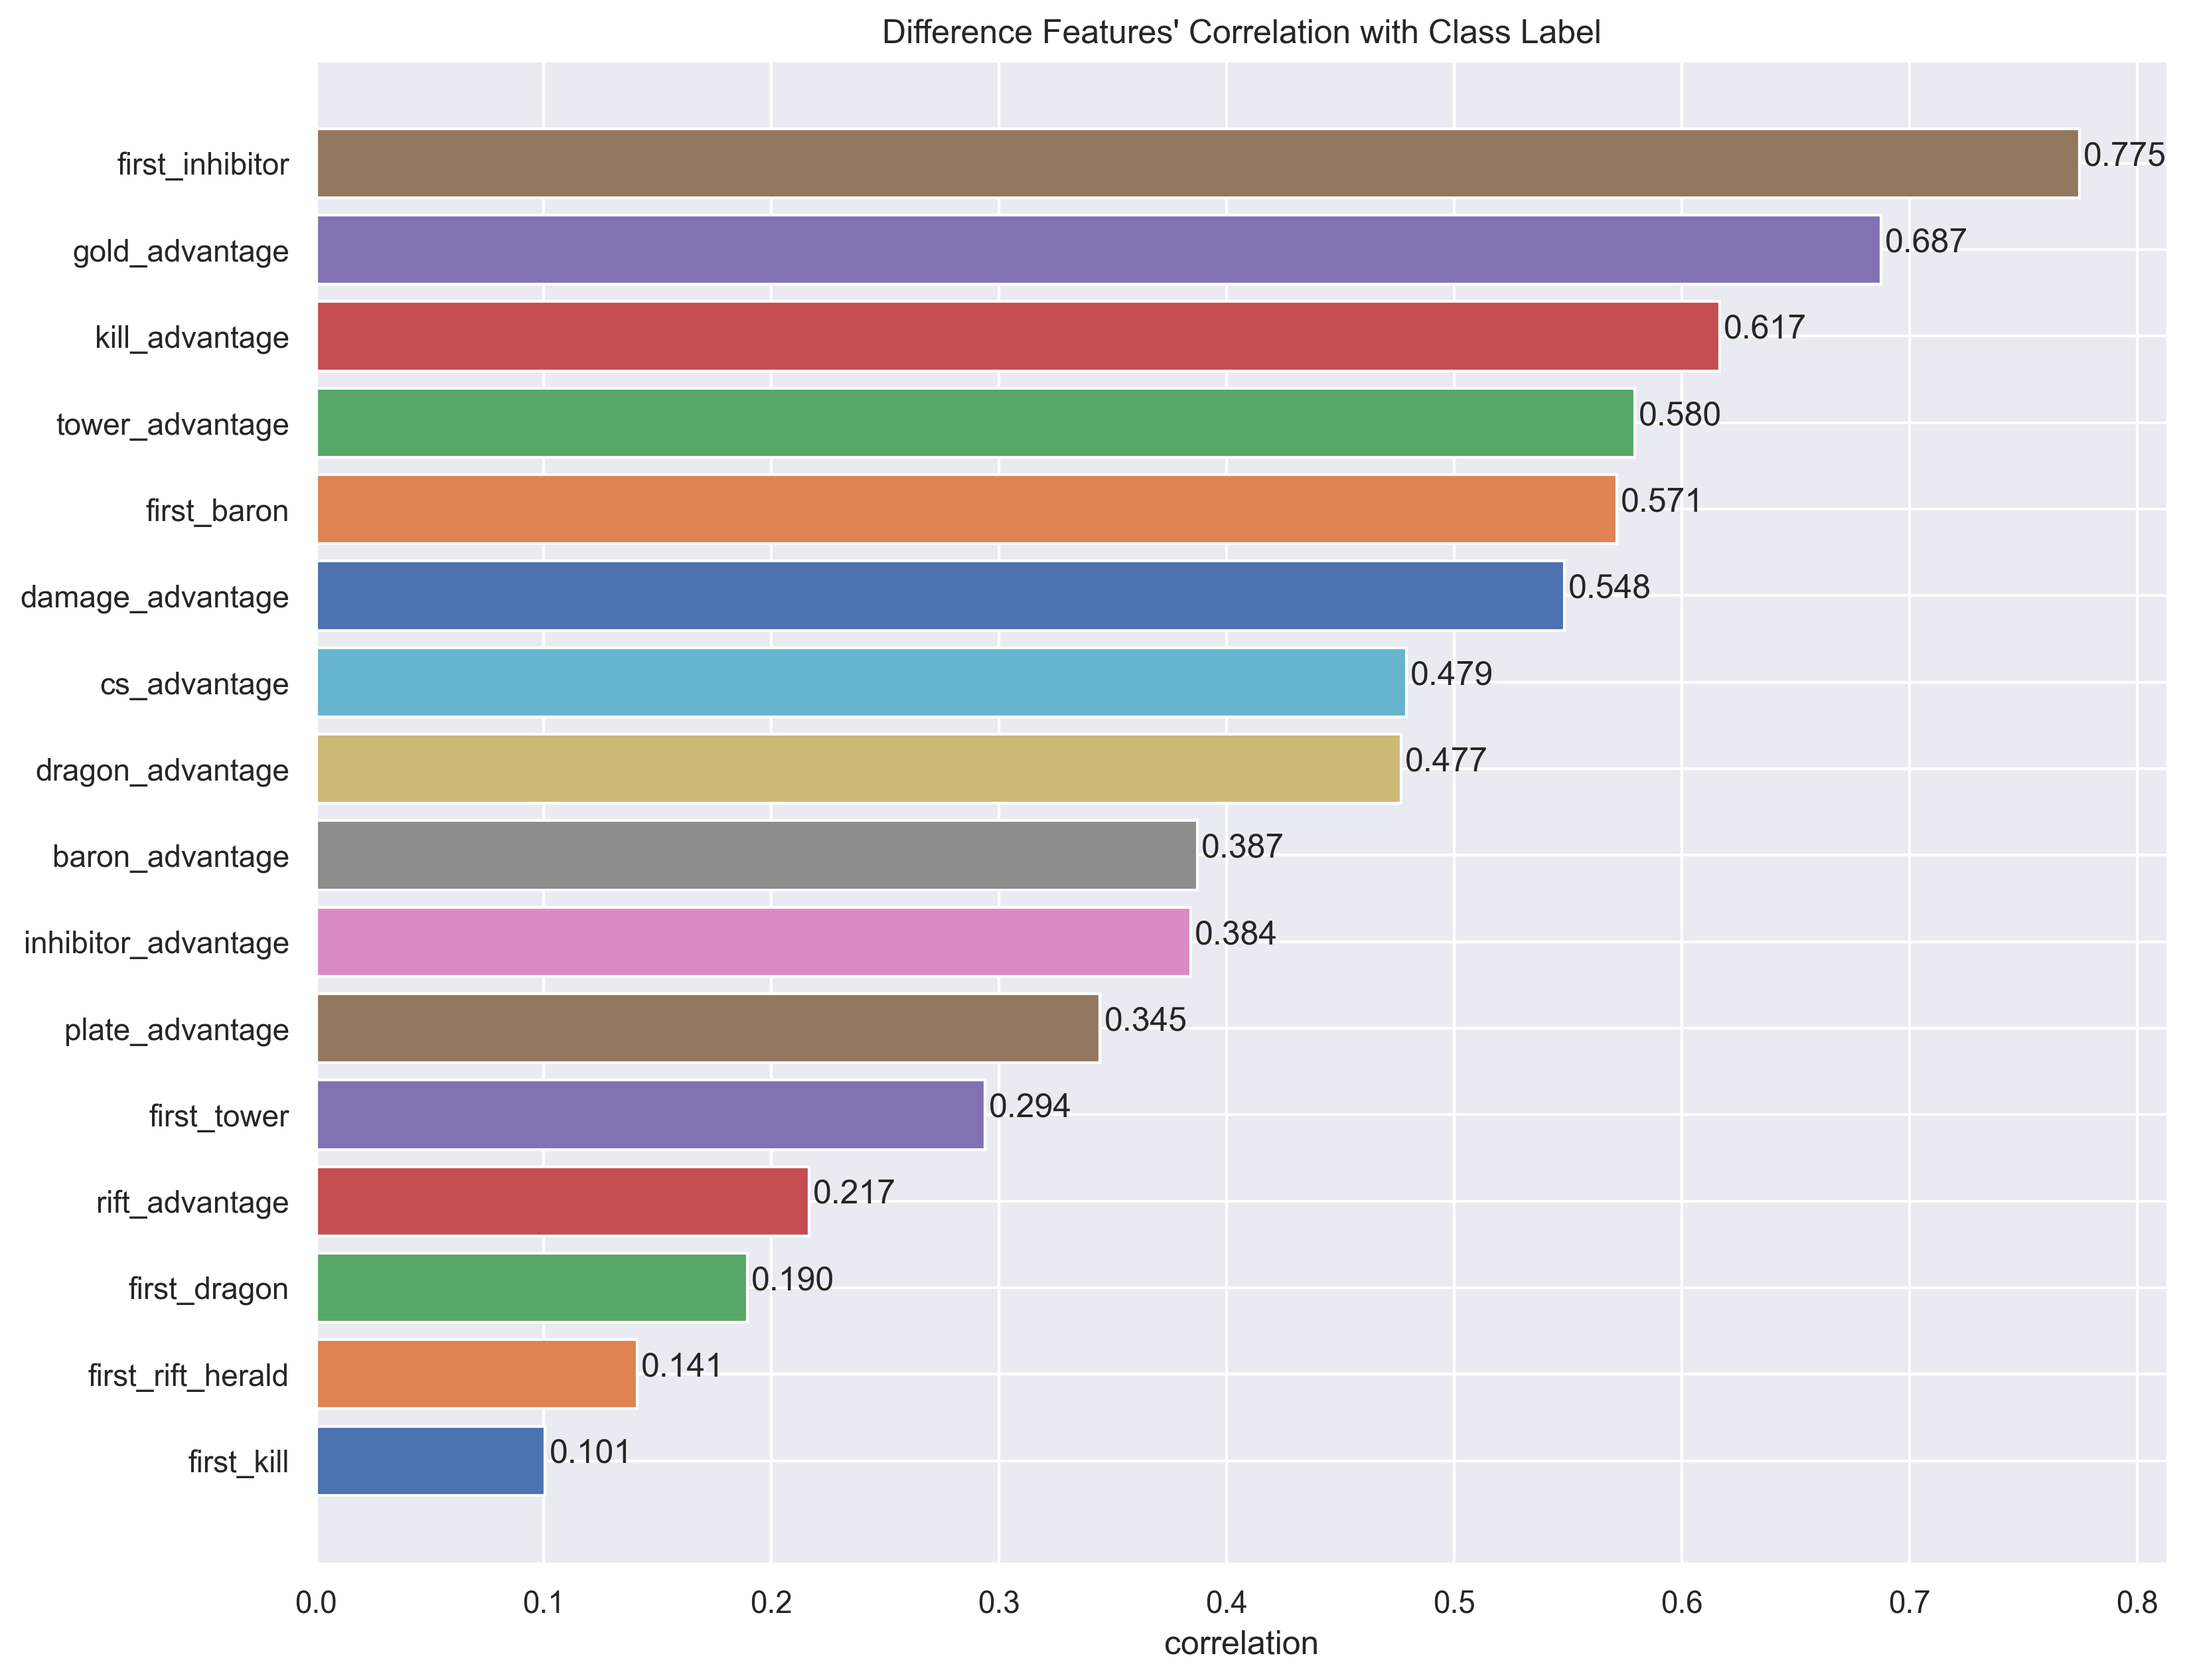

In [31]:
# plotting the correlation of features' transformed using difference method and 
# an initial objective features with class label
plt_df = df_diff_trn.corr()['winner'].drop(['winner'])
plot_correlation_bar_plot(plt_df, title='Difference Features\' Correlation with Class Label')

In [32]:
df_bi_trn.to_csv('../data/processed/bi_trn.csv')
df_bi_tst.to_csv('../data/processed/bi_tst.csv')
df_diff_trn.to_csv('../data/processed/diff_trn.csv')
df_diff_tst.to_csv('../data/processed/diff_tst.csv')